In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [22]:
# Parameters
n = 20  # context length
d = 5  # input dimension
L = 3  # number of layers
batch_size = 512
validation_size = batch_size // 8
epochs = 10000

# purtabation introduced for initialization
delta_initialize = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set seeds

# for PyTorch
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# to ensure reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [23]:
# distribution for x and w
def generate_data(batch_size, d, n, device):
    # x = (torch.rand(batch_size, n+1, d, device=device) - 0.5) * 2 * M  # uniform distribution. of shape (batch_size, n+1, d)
    x = torch.randn(batch_size, n+1, d, device=device) # normal distribution N(0, 1). of shape (batch_size, n+1, d)
    w_star = torch.randn(batch_size, d, device=device)  # normal distribution N(0, 1) of shape (batch_size, d)
    y = (x * w_star.unsqueeze(1)).sum(dim=2) # taking inner product of x_i and w for each batch. of shape(batch_size, n+1)
    return x, y, w_star # y[:,n] are the true y_{n+1} values

class LinearTransformer(nn.Module):
    def __init__(self, d, n, L, delta_init, device):
        super(LinearTransformer, self).__init__()
        self.L = L
        self.n = n
        self.device = device

        # random
        self.P_list = nn.ParameterList([nn.Parameter(torch.randn(d+1, d+1, device=device) * delta_init) for _ in range(L)])
        self.Q_list = nn.ParameterList([nn.Parameter(torch.randn(d+1, d+1, device=device) * delta_init) for _ in range(L)])

        self.M = torch.block_diag(torch.eye(n, device=device), torch.zeros(1,1, device=device))
        # sparse P and Q
    #     self.P_list = nn.ParameterList([self.create_P_matrix(d, device) for _ in range(L)])
    #     self.Q_list = nn.ParameterList([self.create_Q_matrix(d, device) for _ in range(L)])

    # def create_P_matrix(self, d, device):
    #     # create a (d+1) x (d+1) matrix with the desired structure for P_i
    #     P = torch.zeros(d+1, d+1, device=device)
    #     P[-1, -1] = 1
    #     return nn.Parameter(P)

    # def create_Q_matrix(self, d, device):
    #     # create a (d+1) x (d+1) matrix with the desired structure for Q_i
    #     Q = torch.zeros(d+1, d+1, device=device)
    #     A_i = torch.randn(d, d, device=device) * 0.1  # initialize A_i randomly
    #     Q[:d, :d] = A_i  # Place A_i in the top-left block
    #     return nn.Parameter(-Q)

        # small number
        #self.P_list = nn.ParameterList([nn.Parameter(torch.ones(d+1, d+1, device=device) * 0.001) for _ in range(L)])
        #self.Q_list = nn.ParameterList([nn.Parameter(torch.ones(d+1, d+1, device=device) * 0.001) for _ in range(L)])

        # zero doesn't work
        # self.P_list = nn.ParameterList([nn.Parameter(torch.zeros(d+1, d+1, device=device)) for _ in range(L)])
        # self.Q_list = nn.ParameterList([nn.Parameter(torch.zeros(d+1, d+1, device=device)) for _ in range(L)])

    def forward(self, Z):
        # Z is given as shape (batch_size, d+!, n+1)
        batch_size = Z.shape[0]
        for l in range(self.L):
            P = self.P_list[l]
            Q = self.Q_list[l]
            # batched version of Z_tilde = Z.T @ Q @ Z
            Z_tilde = torch.bmm(Z.transpose(1, 2), Q.unsqueeze(0).expand(batch_size, -1, -1))
            Z_tilde = torch.bmm(Z_tilde, Z)

            # batched version of Attn_PQ = P @ Z @ self.M @ Z_tilde
            Attn_PQ = torch.bmm(P.unsqueeze(0).expand(batch_size, -1, -1), Z)
            Attn_PQ = torch.bmm(Attn_PQ, self.M.unsqueeze(0).expand(batch_size, -1, -1))
            Attn_PQ = torch.bmm(Attn_PQ, Z_tilde)
            Z = Z + Attn_PQ / self.n
        return Z

In [15]:
def loss_function(ZL, y_true):
    y_hat = -ZL[:,-1,-1] # shape (batch_size,)
    return torch.mean((y_hat - y_true)**2)

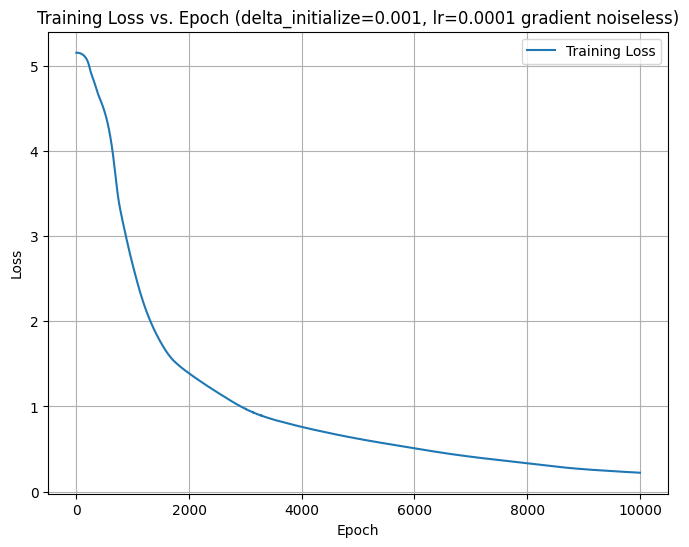

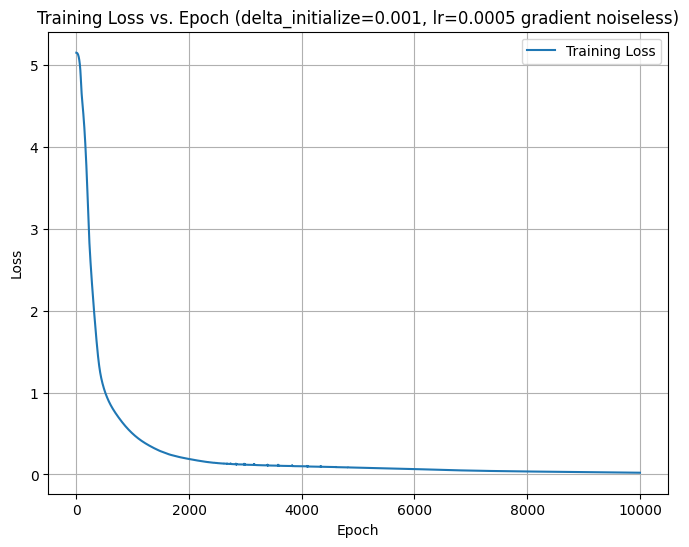

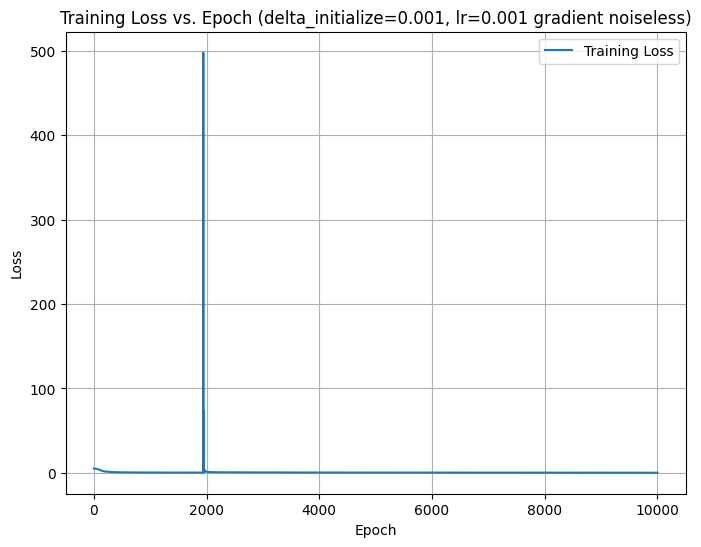

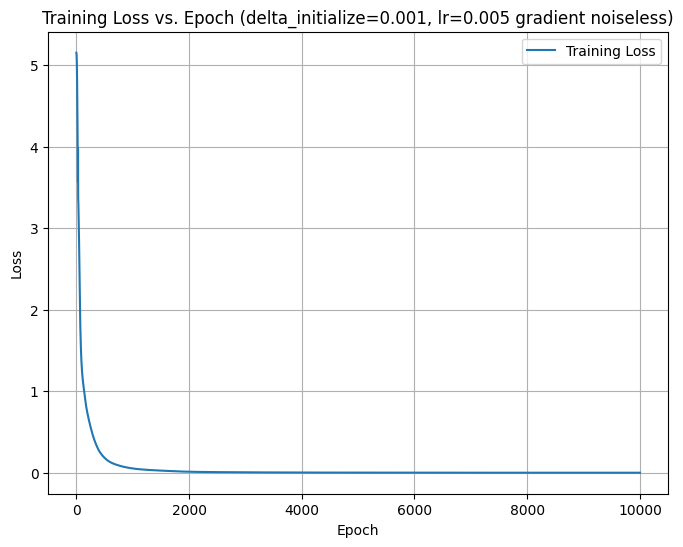

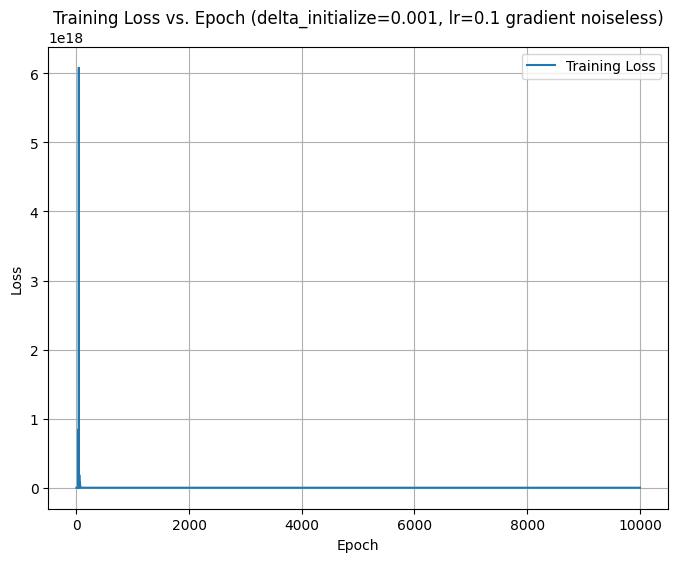

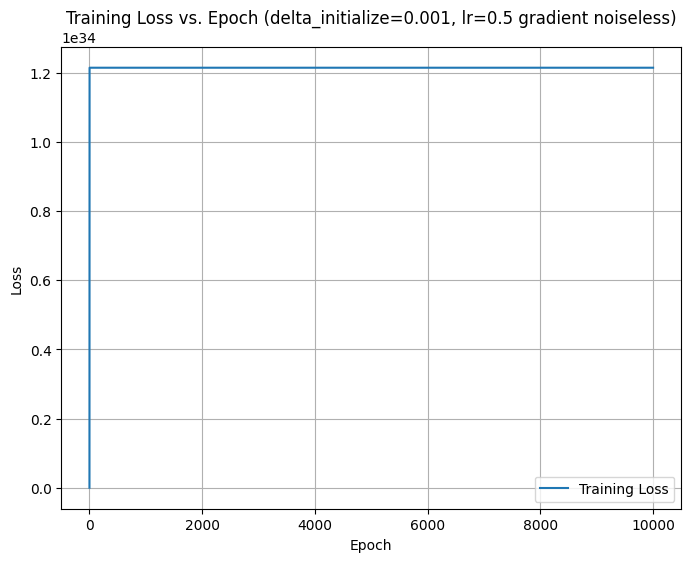

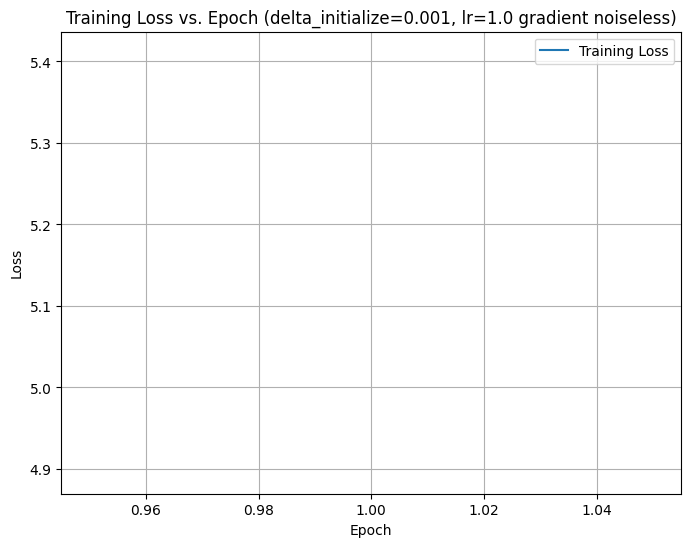

In [17]:
# Hyperparameters for Adam optimizer
lr = 0.005
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Function to apply Adam updates with added noise to the gradient
def adam_step(params, grads, m, v, t, lr, beta1, beta2, epsilon, noise_scale):
    updated_params = []
    for idx, (param, grad) in enumerate(zip(params, grads)):
        # Add noise to gradient
        noisy_grad = grad + torch.randn_like(grad) * noise_scale

        # Update biased first moment estimate
        m[idx] = beta1 * m[idx] + (1 - beta1) * noisy_grad

        # Update biased second moment estimate
        v[idx] = beta2 * v[idx] + (1 - beta2) * (noisy_grad ** 2)

        # Compute bias-corrected first moment estimate
        m_hat = m[idx] / (1 - beta1 ** t)

        # Compute bias-corrected second moment estimate
        v_hat = v[idx] / (1 - beta2 ** t)

        # Update parameters
        param_update = param - lr * m_hat / (torch.sqrt(v_hat) + epsilon)
        updated_params.append(param_update)

    return updated_params, m, v

noise_unit = 0.5

lr_choice = [0.0001, 0.0005, 0.001, 0.005, 0.1, 0.5, 1.0]

train_x, train_y, _ = generate_data(batch_size, d, n, device)

for lr_idx in range(len(lr_choice)):
    for iter in range(1):
        # initialize the model, optimizer, and loss function
        model = LinearTransformer(d=d, n=n, L=L, delta_init=delta_initialize, device=device).to(device)

        # Adam's momentum (m) and second moment (v) terms
        m = [torch.zeros_like(param) for param in model.parameters()]
        v = [torch.zeros_like(param) for param in model.parameters()]

        train_losses = []

        for epoch in range(epochs):
            model.train()

            # zero-out gradients manually before each training step
            for param in model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            # forward pass and loss calculation
            Z0 = torch.cat((torch.transpose(train_x,1,2), train_y.unsqueeze(1)), dim=1)  # concatenating x and y to form Z
            Z0[:,-1,-1] = 0 # initialize y_{n+1} as 0
            ZL = model(Z0)  # Apply the linear transformer
            train_loss = loss_function(ZL, train_y[:,-1])

            # backward pass and manual Adam update with noise
            grads = torch.autograd.grad(train_loss, model.parameters(), create_graph=False)

            # Set updated parameters back to the model
            with torch.no_grad():
                # manually perform an Adam step with noisy gradients
                updated_params, m, v = adam_step(list(model.parameters()), grads, m, v, epoch+1, lr_choice[lr_idx], beta1, beta2, epsilon, noise_scale=0)# noise_unit * noise_grade)
                for param, updated_param in zip(model.parameters(), updated_params):
                    param.copy_(updated_param)


            train_losses.append(train_loss.item())

        # Plot the loss over epochs
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training Loss vs. Epoch (delta_initialize={delta_initialize}, lr={lr_choice[lr_idx]} gradient noiseless)')
        plt.legend()
        plt.grid(True)
        plt.show()

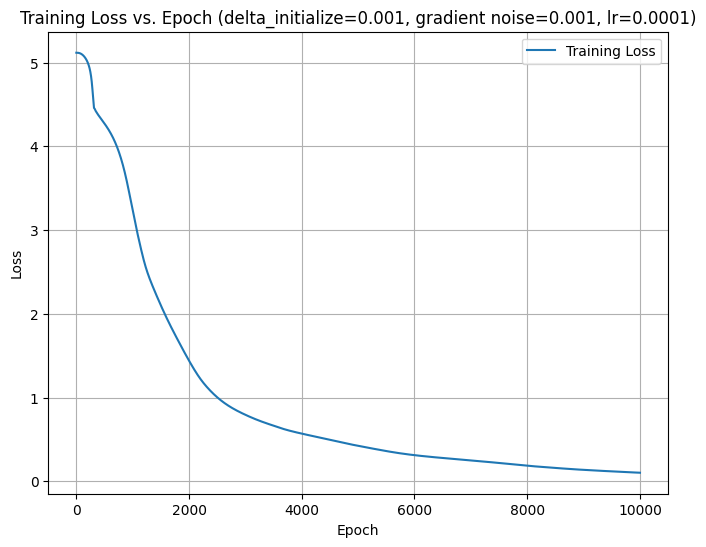

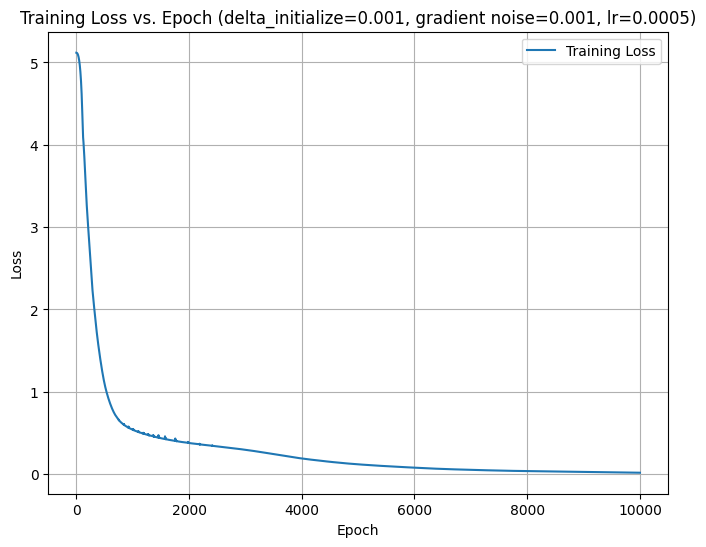

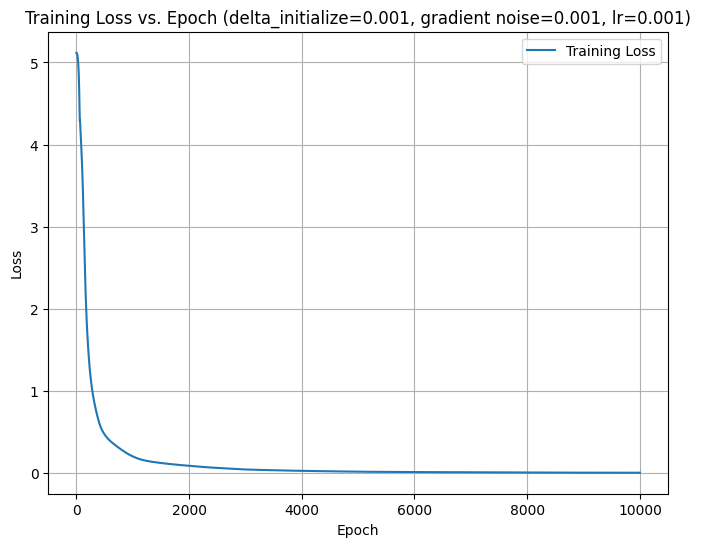

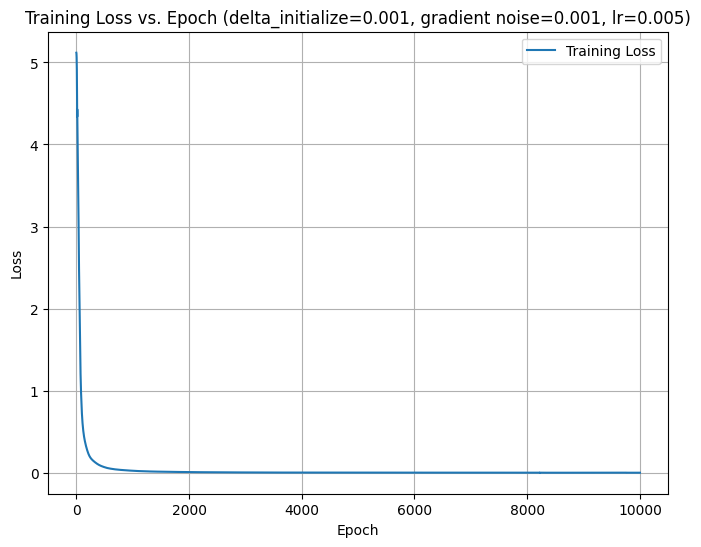

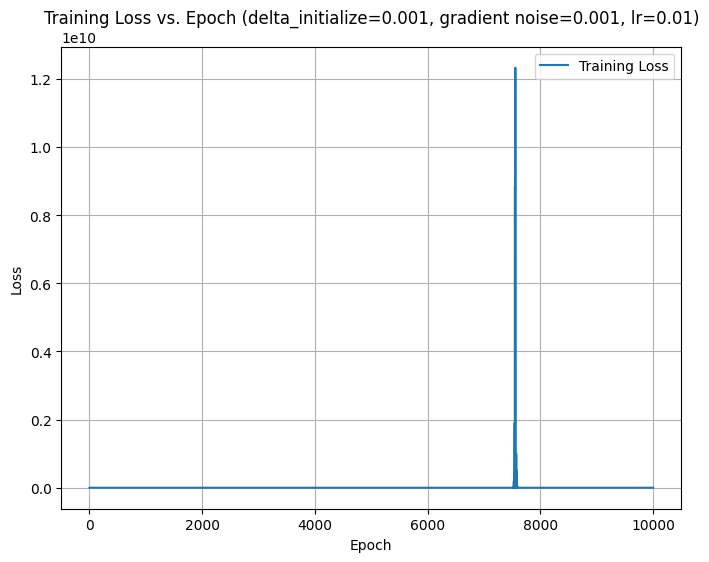

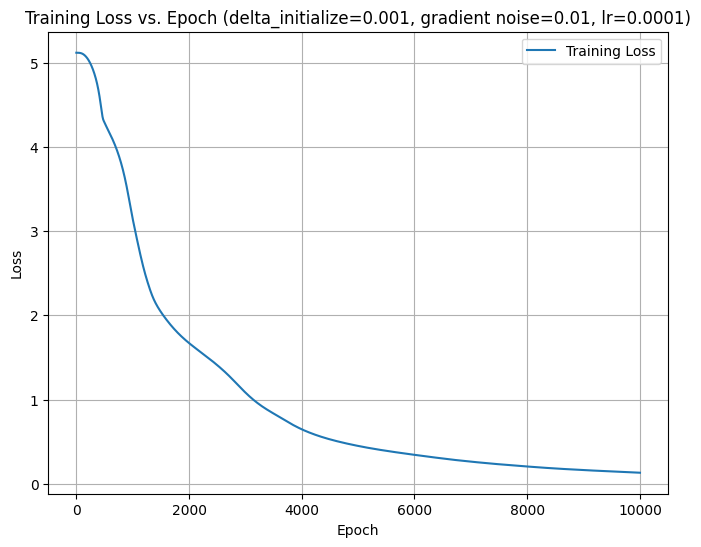

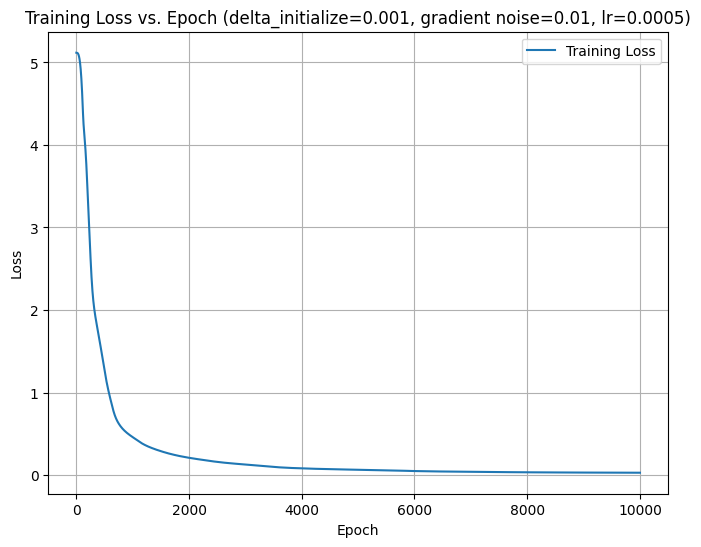

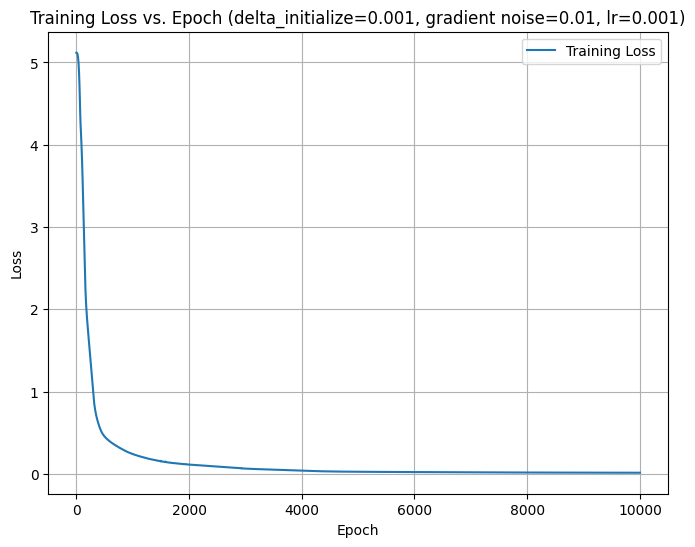

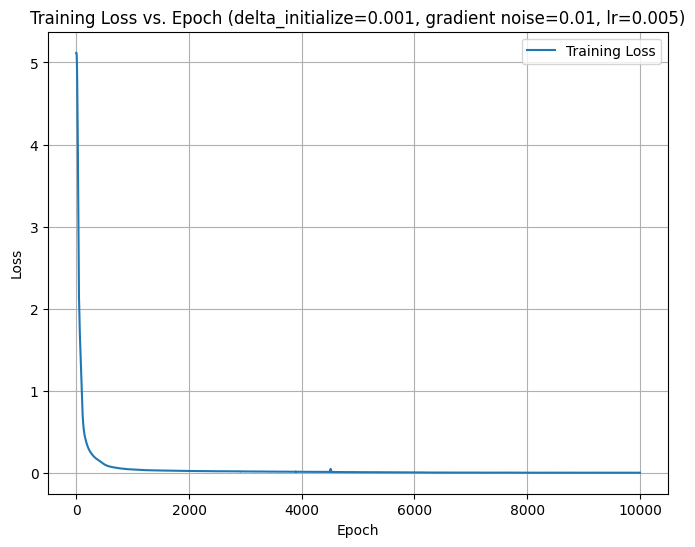

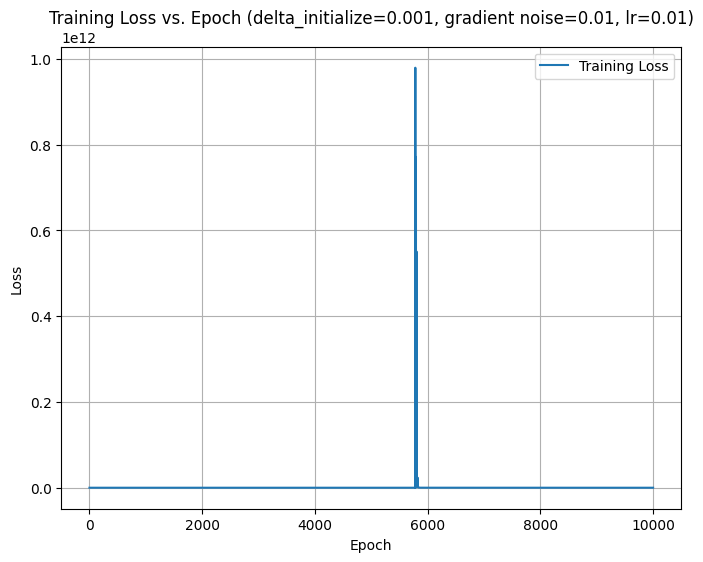

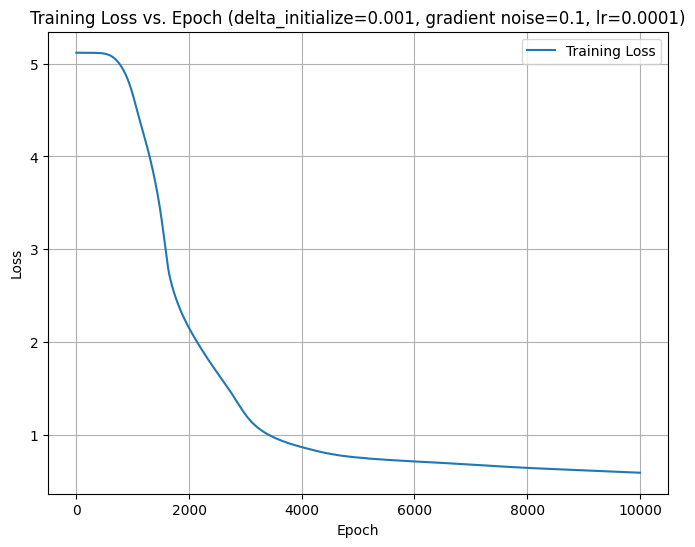

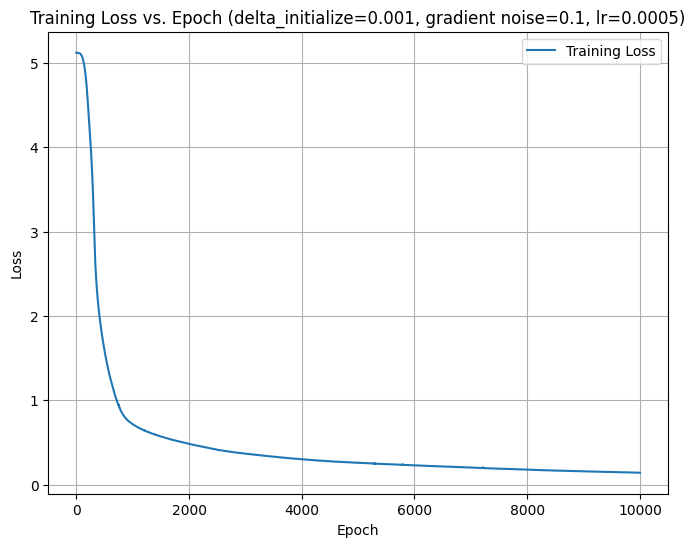

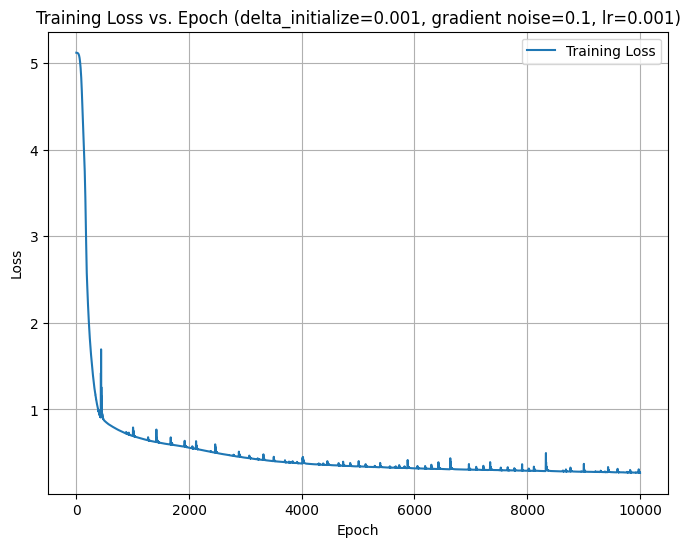

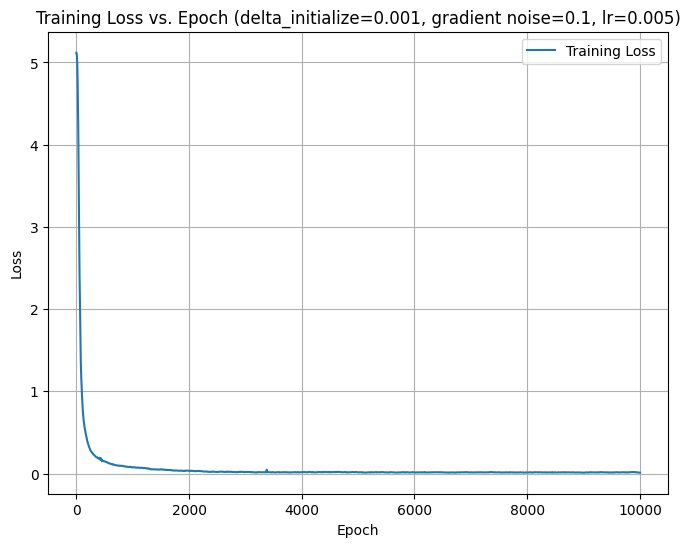

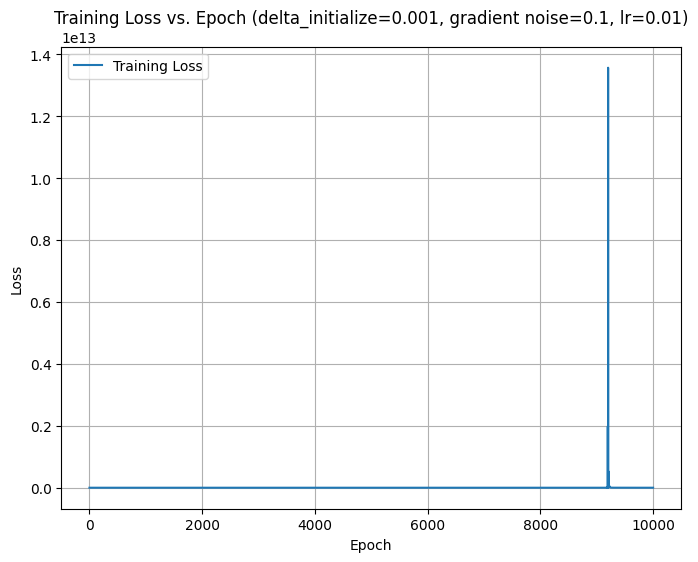

In [18]:
# Hyperparameters for Adam optimizer
# lr = 0.005
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Function to apply Adam updates with added noise to the gradient
def adam_step(params, grads, m, v, t, lr, beta1, beta2, epsilon, noise_scale):
    updated_params = []
    for idx, (param, grad) in enumerate(zip(params, grads)):
        # Add noise to gradient
        noisy_grad = grad + torch.randn_like(grad) * noise_scale

        # Update biased first moment estimate
        m[idx] = beta1 * m[idx] + (1 - beta1) * noisy_grad

        # Update biased second moment estimate
        v[idx] = beta2 * v[idx] + (1 - beta2) * (noisy_grad ** 2)

        # Compute bias-corrected first moment estimate
        m_hat = m[idx] / (1 - beta1 ** t)

        # Compute bias-corrected second moment estimate
        v_hat = v[idx] / (1 - beta2 ** t)

        # Update parameters
        param_update = param - lr * m_hat / (torch.sqrt(v_hat) + epsilon)
        updated_params.append(param_update)

    return updated_params, m, v

noise_choice = [0.001, 0.01, 0.1]
lr_choice = [0.0001, 0.0005, 0.001, 0.005, 0.01]

train_x, train_y, _ = generate_data(batch_size, d, n, device)

for noise_idx in range(len(noise_choice)):
    noise = noise_choice[noise_idx]
    for lr_idx in range(len(lr_choice)):
        lr = lr_choice[lr_idx]
        # initialize the model, optimizer, and loss function
        model = LinearTransformer(d=d, n=n, L=L, delta_init=delta_initialize, device=device).to(device)

        # Adam's momentum (m) and second moment (v) terms
        m = [torch.zeros_like(param) for param in model.parameters()]
        v = [torch.zeros_like(param) for param in model.parameters()]

        train_losses = []

        for epoch in range(epochs):
            model.train()

            # zero-out gradients manually before each training step
            for param in model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            # forward pass and loss calculation
            Z0 = torch.cat((torch.transpose(train_x,1,2), train_y.unsqueeze(1)), dim=1)  # concatenating x and y to form Z
            Z0[:,-1,-1] = 0 # initialize y_{n+1} as 0
            ZL = model(Z0)  # Apply the linear transformer
            train_loss = loss_function(ZL, train_y[:,-1])

            # backward pass and manual Adam update with noise
            grads = torch.autograd.grad(train_loss, model.parameters(), create_graph=False)

            # Set updated parameters back to the model
            with torch.no_grad():
                # manually perform an Adam step with noisy gradients
                updated_params, m, v = adam_step(list(model.parameters()), grads, m, v, epoch+1, lr, beta1, beta2, epsilon, noise_scale=noise)
                for param, updated_param in zip(model.parameters(), updated_params):
                    param.copy_(updated_param)


            train_losses.append(train_loss.item())

        # Plot the loss over epochs
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training Loss vs. Epoch (delta_initialize={delta_initialize}, gradient noise={noise}, lr={lr})')
        plt.legend()
        plt.grid(True)
        plt.show()

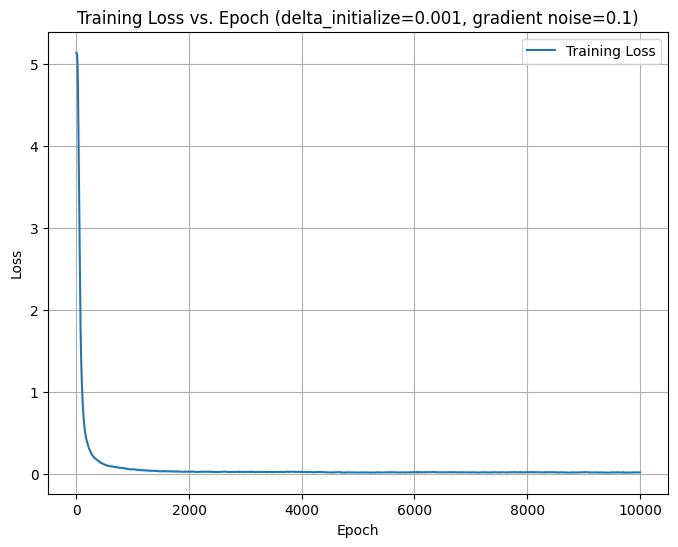

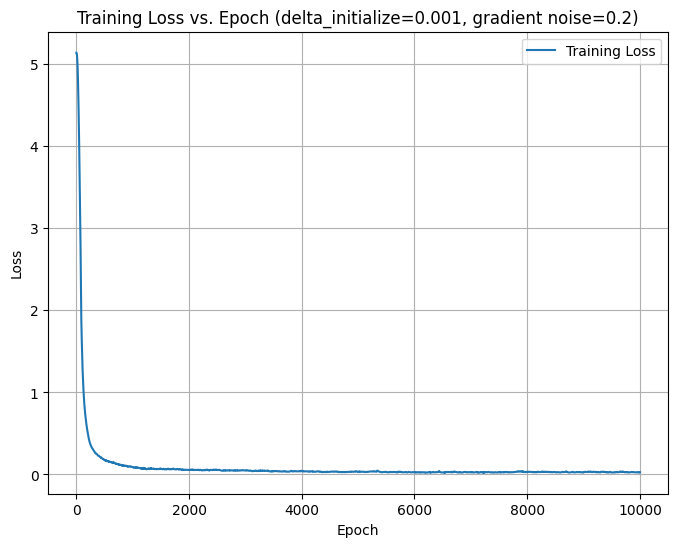

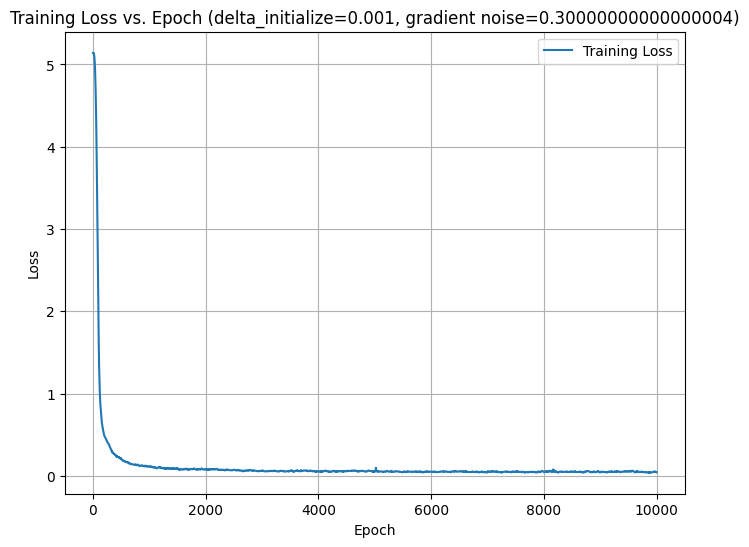

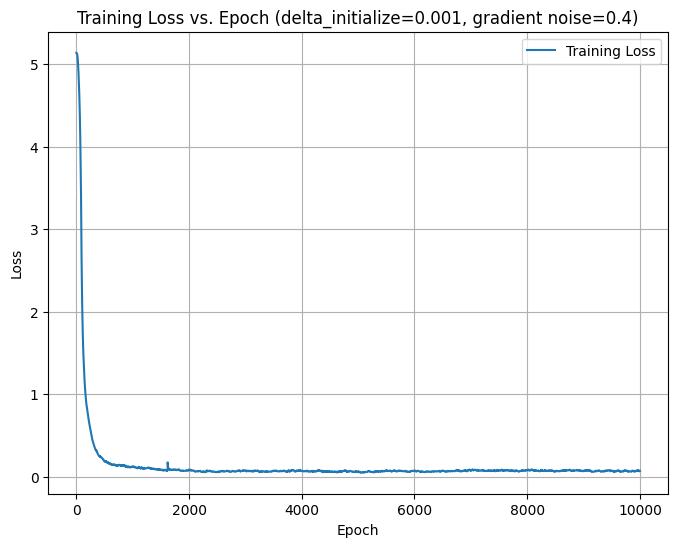

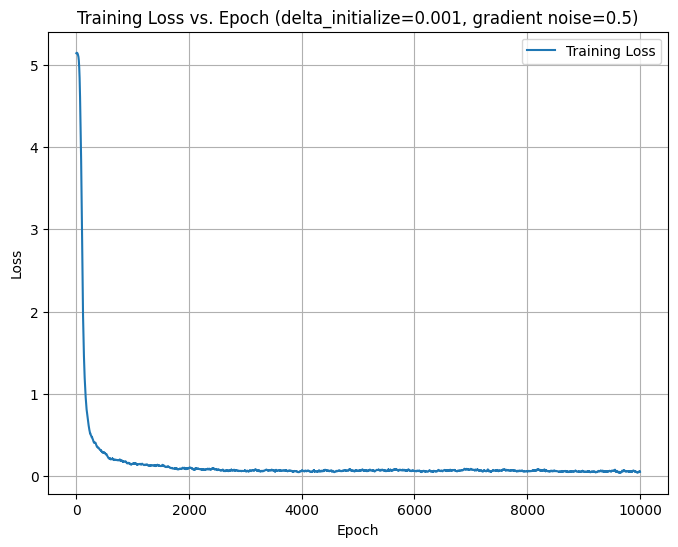

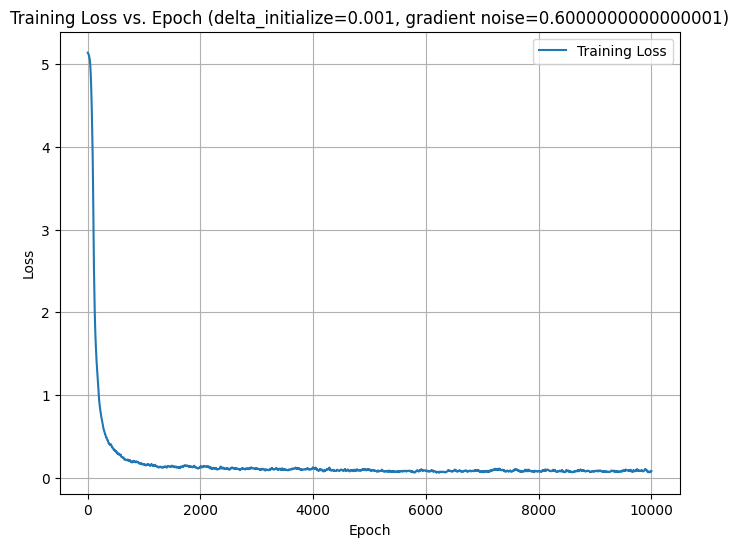

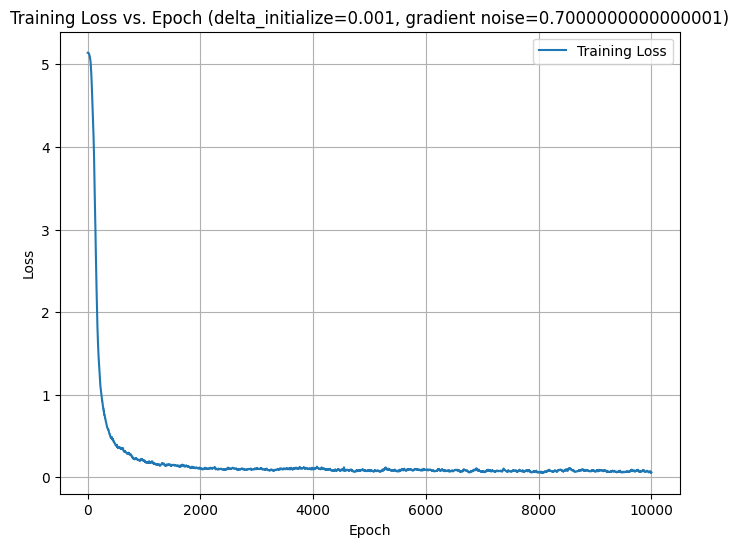

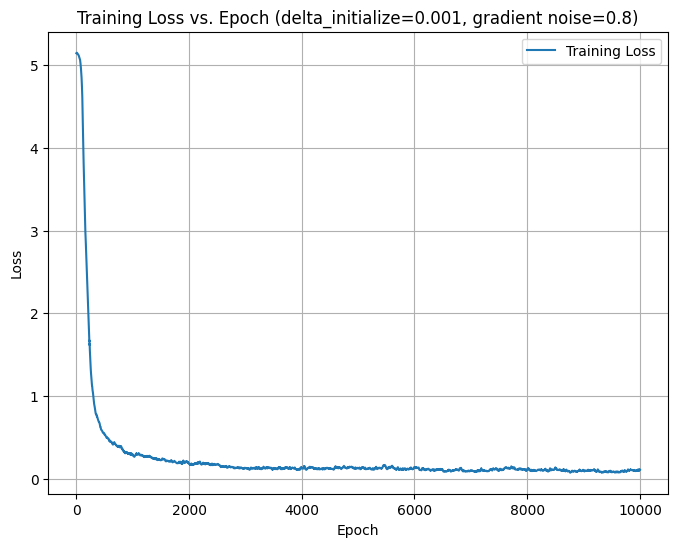

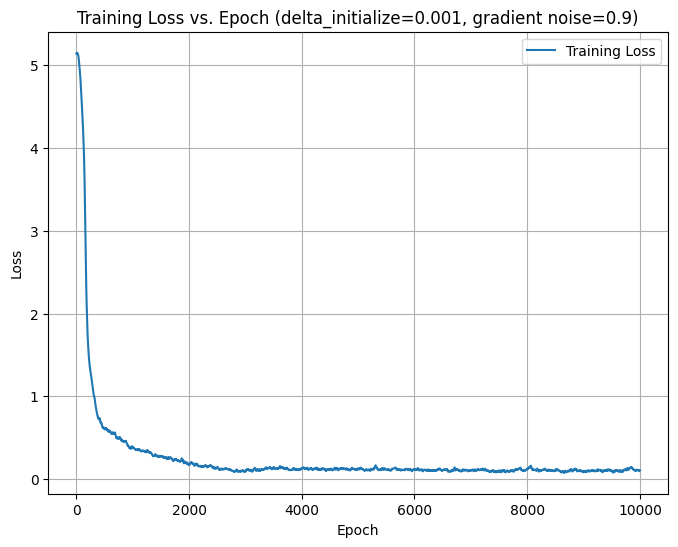

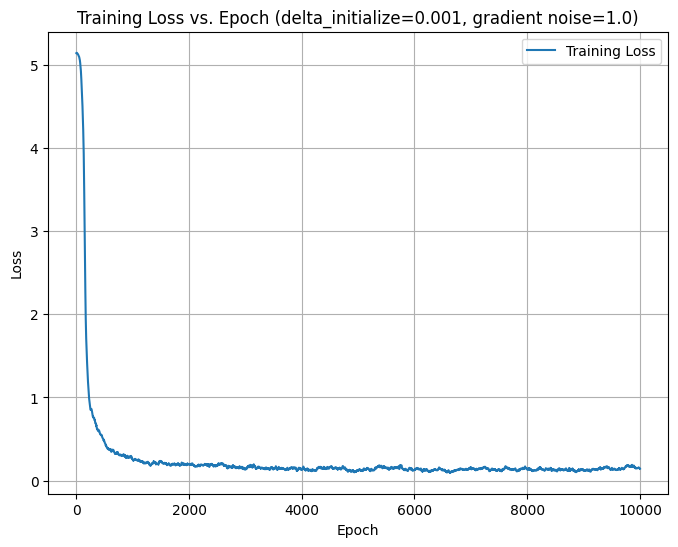

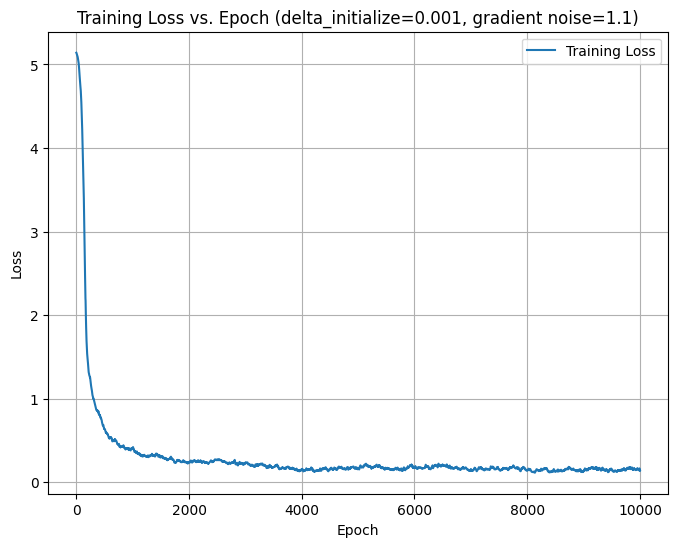

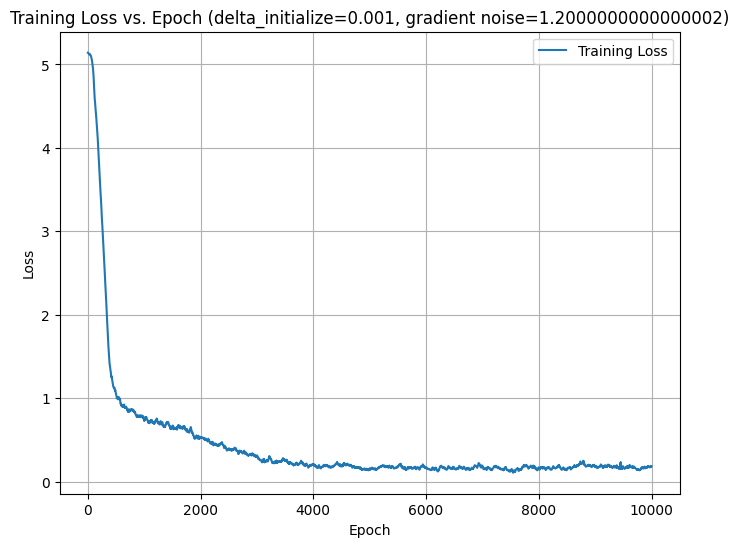

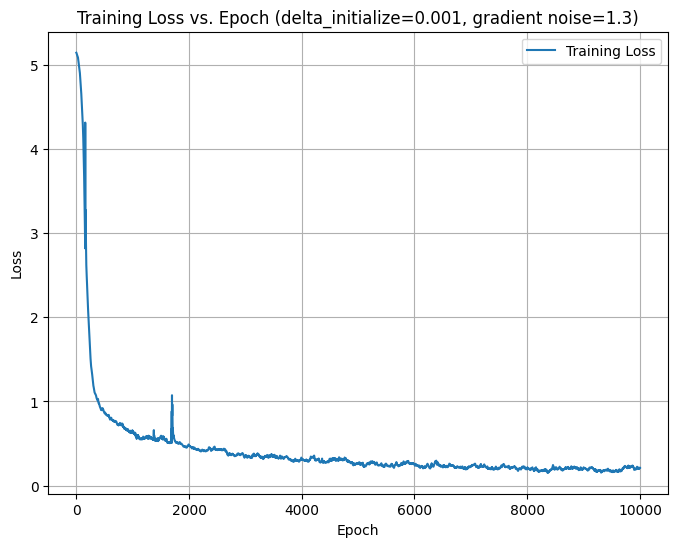

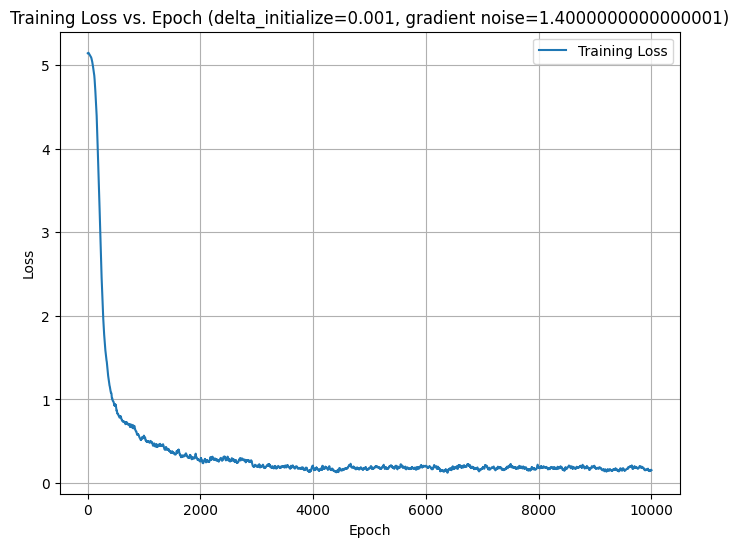

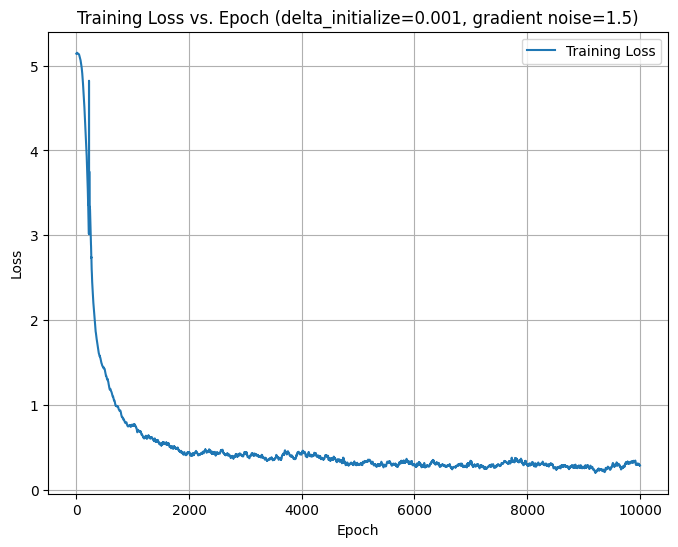

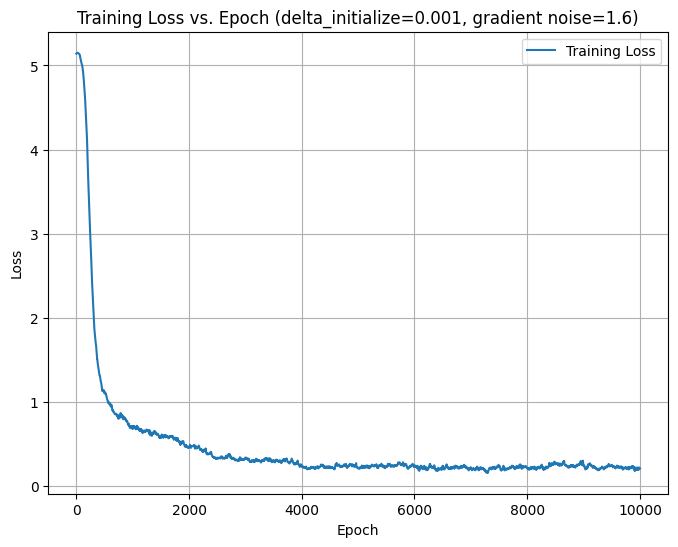

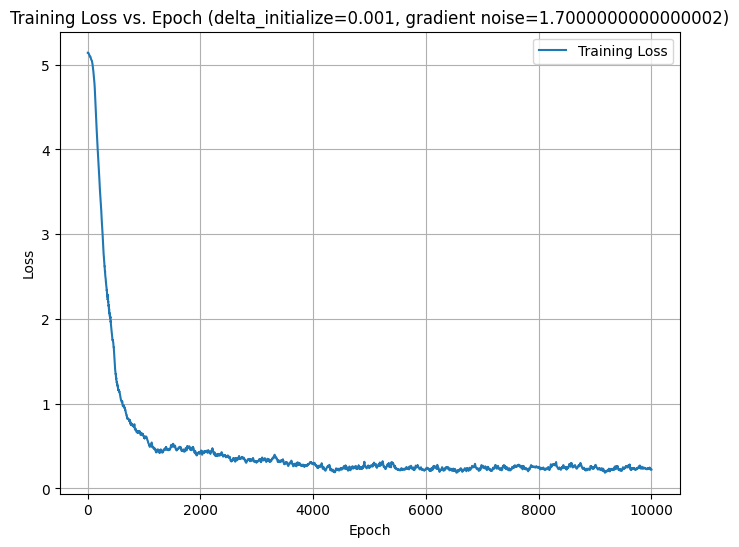

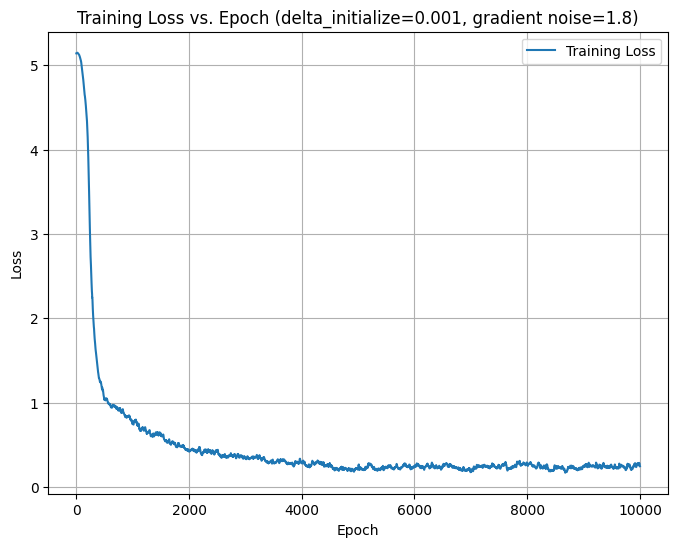

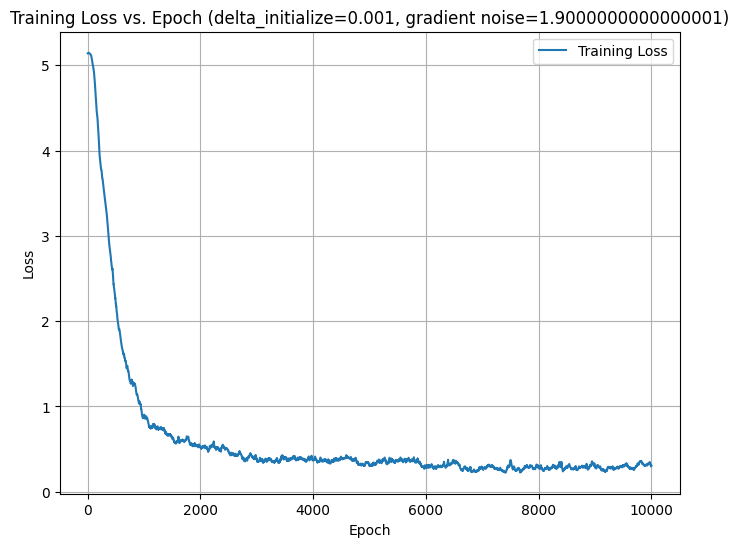

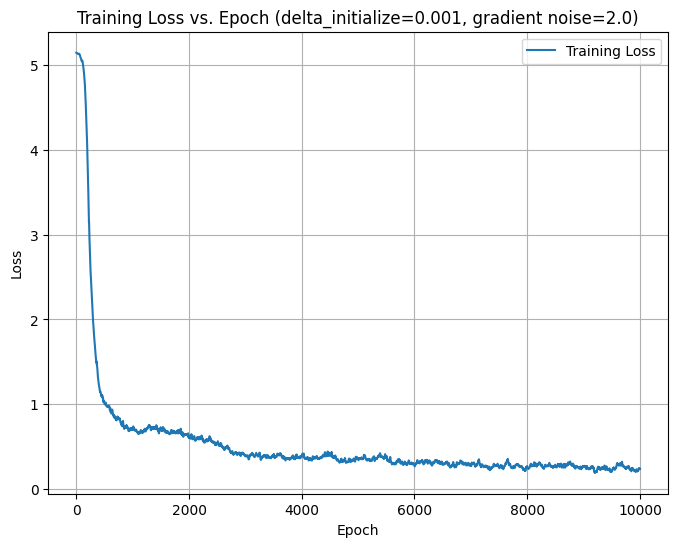

In [19]:
# Hyperparameters for Adam optimizer
lr = 0.005
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Function to apply Adam updates with added noise to the gradient
def adam_step(params, grads, m, v, t, lr, beta1, beta2, epsilon, noise_scale):
    updated_params = []
    for idx, (param, grad) in enumerate(zip(params, grads)):
        # Add noise to gradient
        noisy_grad = grad + torch.randn_like(grad) * noise_scale

        # Update biased first moment estimate
        m[idx] = beta1 * m[idx] + (1 - beta1) * noisy_grad

        # Update biased second moment estimate
        v[idx] = beta2 * v[idx] + (1 - beta2) * (noisy_grad ** 2)

        # Compute bias-corrected first moment estimate
        m_hat = m[idx] / (1 - beta1 ** t)

        # Compute bias-corrected second moment estimate
        v_hat = v[idx] / (1 - beta2 ** t)

        # Update parameters
        param_update = param - lr * m_hat / (torch.sqrt(v_hat) + epsilon)
        updated_params.append(param_update)

    return updated_params, m, v

noise_choice = [0.1 * i for i in range(1,21)]

train_x, train_y, _ = generate_data(batch_size, d, n, device)

for noise_idx in range(len(noise_choice)):
    noise = noise_choice[noise_idx]
    for _ in range(1):
        # initialize the model, optimizer, and loss function
        model = LinearTransformer(d=d, n=n, L=L, delta_init=delta_initialize, device=device).to(device)

        # Adam's momentum (m) and second moment (v) terms
        m = [torch.zeros_like(param) for param in model.parameters()]
        v = [torch.zeros_like(param) for param in model.parameters()]

        train_losses = []

        for epoch in range(epochs):
            model.train()

            # zero-out gradients manually before each training step
            for param in model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            # forward pass and loss calculation
            Z0 = torch.cat((torch.transpose(train_x,1,2), train_y.unsqueeze(1)), dim=1)  # concatenating x and y to form Z
            Z0[:,-1,-1] = 0 # initialize y_{n+1} as 0
            ZL = model(Z0)  # Apply the linear transformer
            train_loss = loss_function(ZL, train_y[:,-1])

            # backward pass and manual Adam update with noise
            grads = torch.autograd.grad(train_loss, model.parameters(), create_graph=False)

            # Set updated parameters back to the model
            with torch.no_grad():
                # manually perform an Adam step with noisy gradients
                updated_params, m, v = adam_step(list(model.parameters()), grads, m, v, epoch+1, lr, beta1, beta2, epsilon, noise_scale=noise)
                for param, updated_param in zip(model.parameters(), updated_params):
                    param.copy_(updated_param)


            train_losses.append(train_loss.item())

        # Plot the loss over epochs
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training Loss vs. Epoch (delta_initialize={delta_initialize}, gradient noise={noise})')
        plt.legend()
        plt.grid(True)
        plt.show()

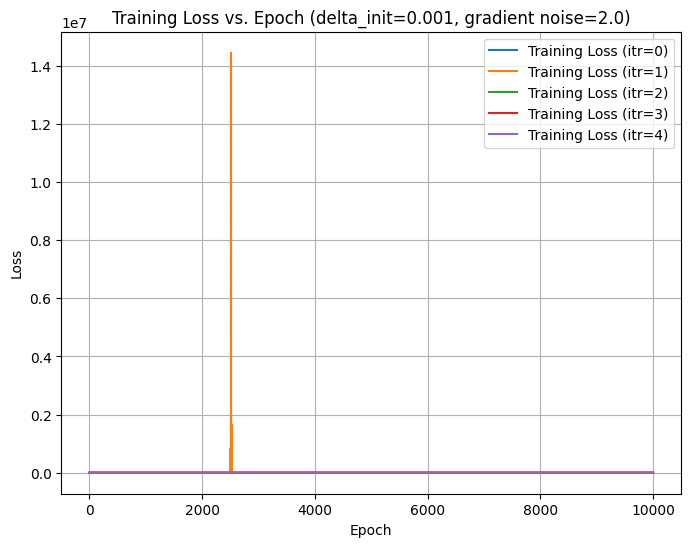

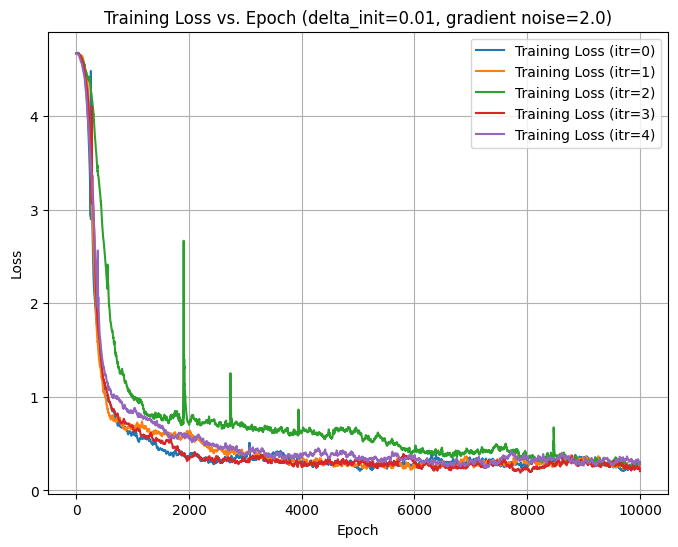

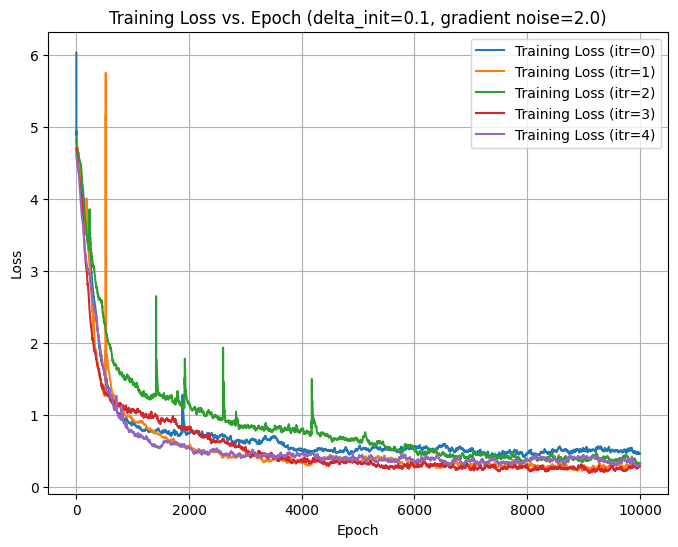

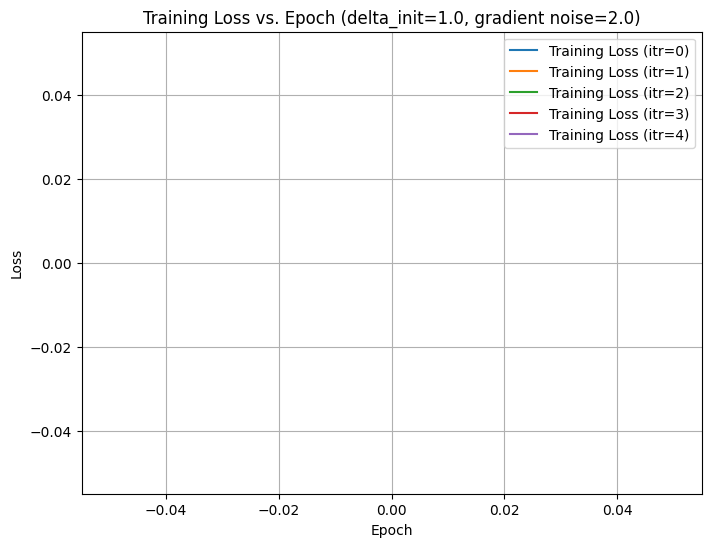

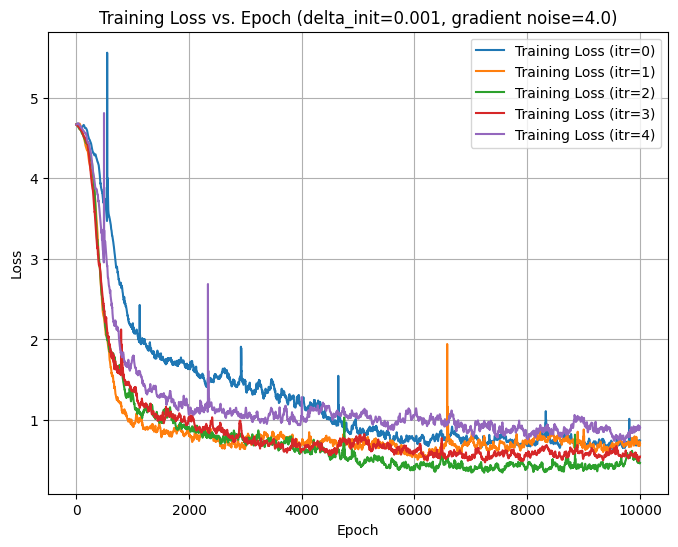

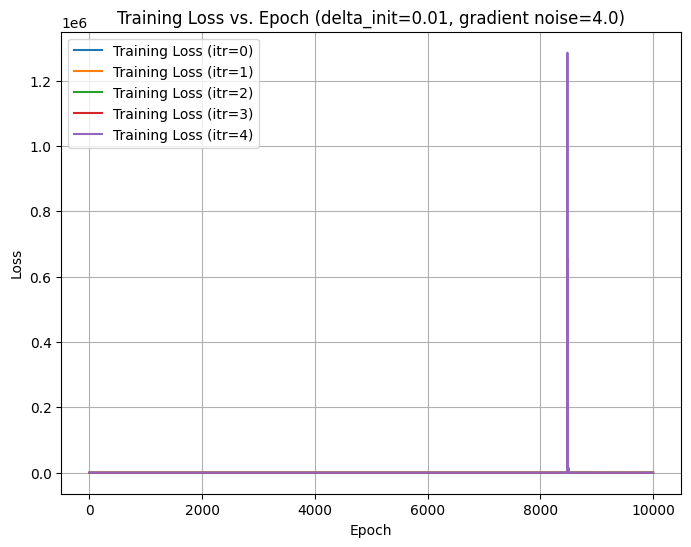

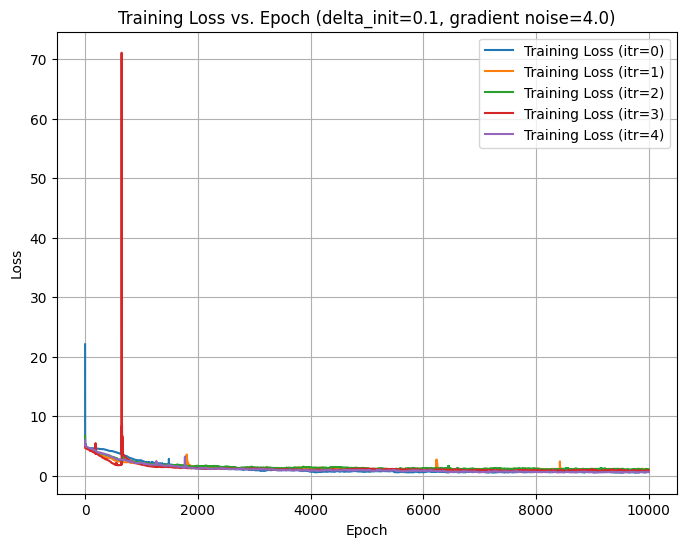

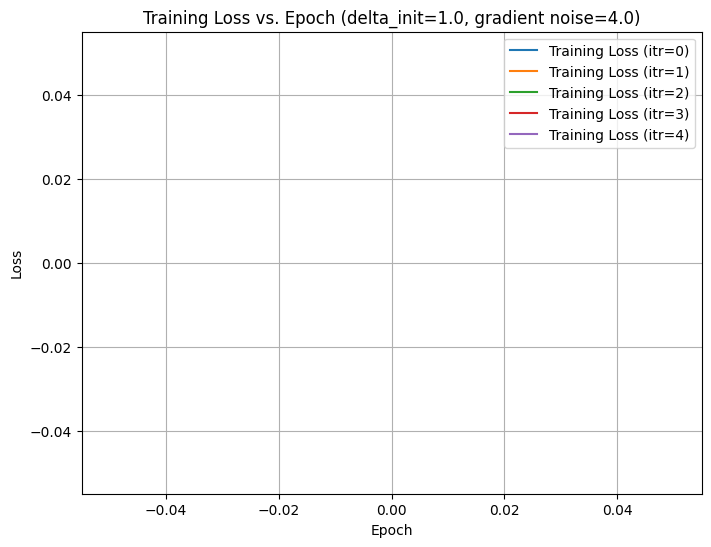

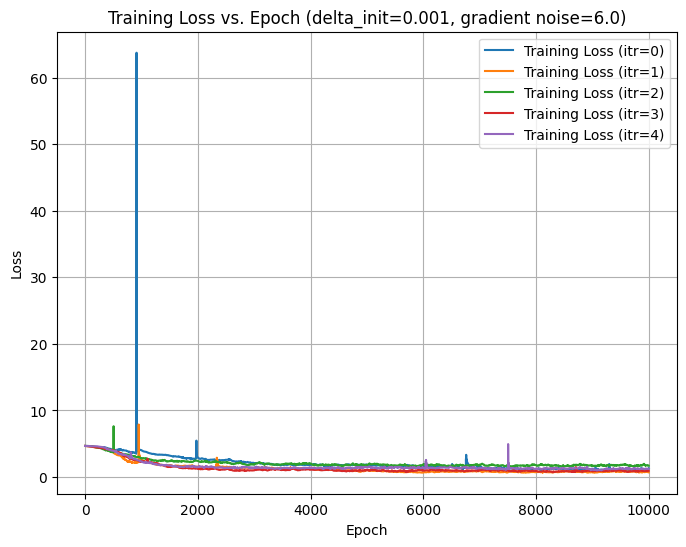

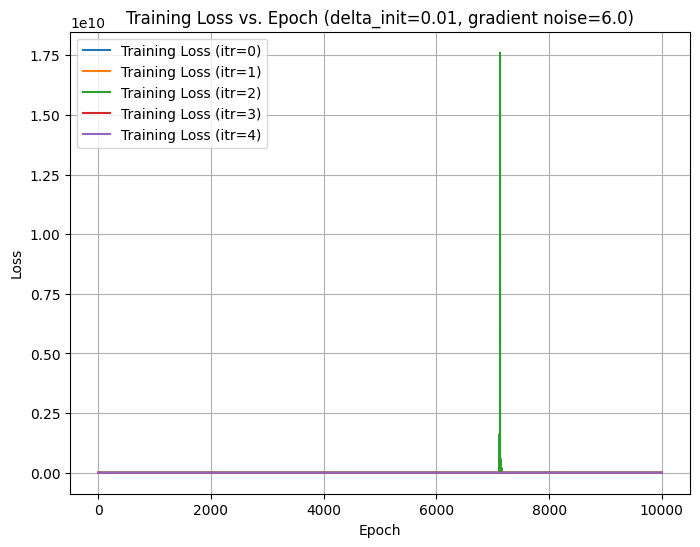

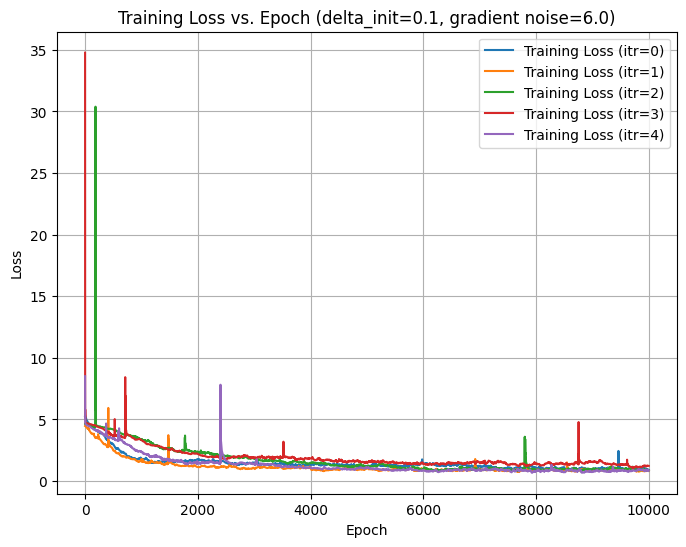

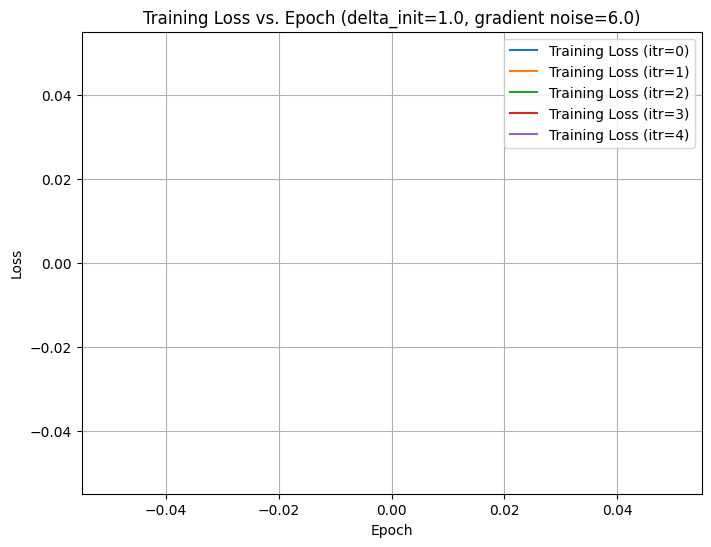

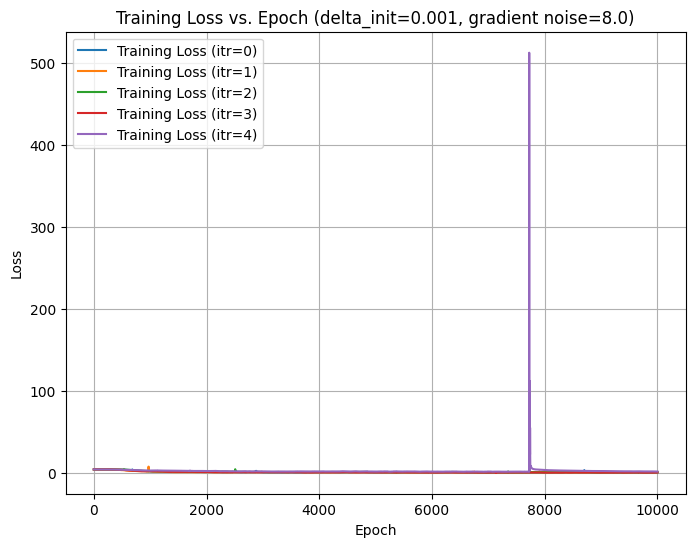

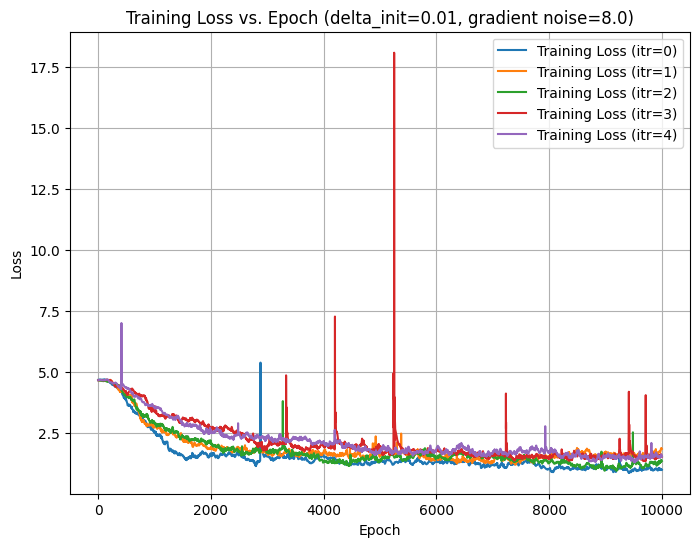

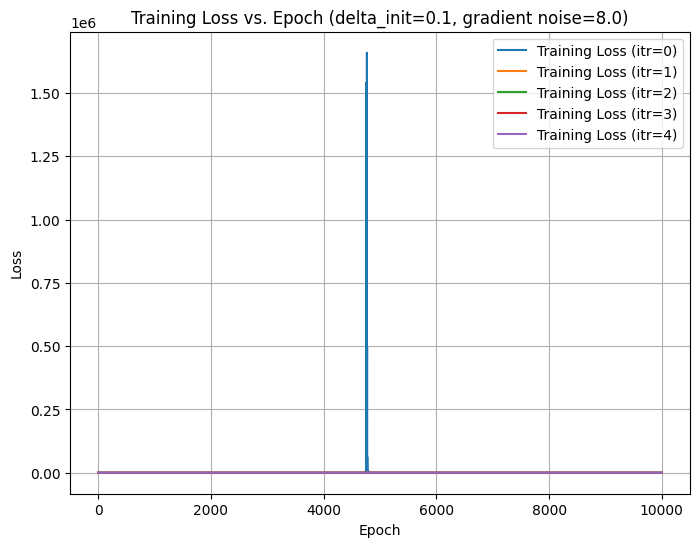

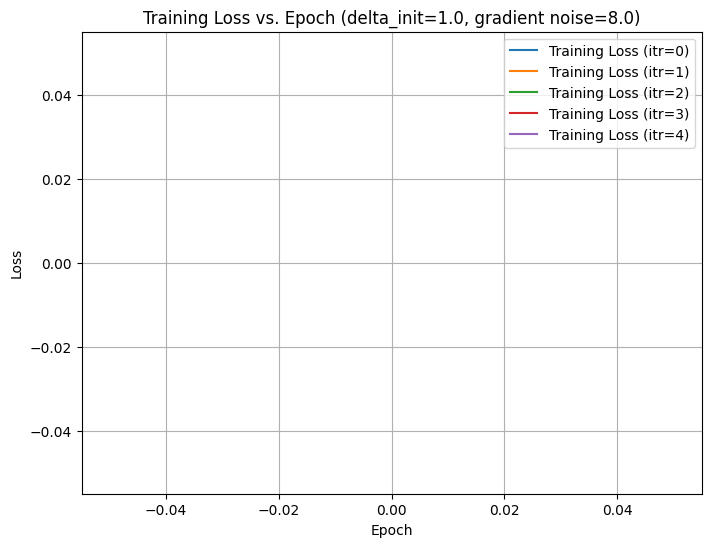

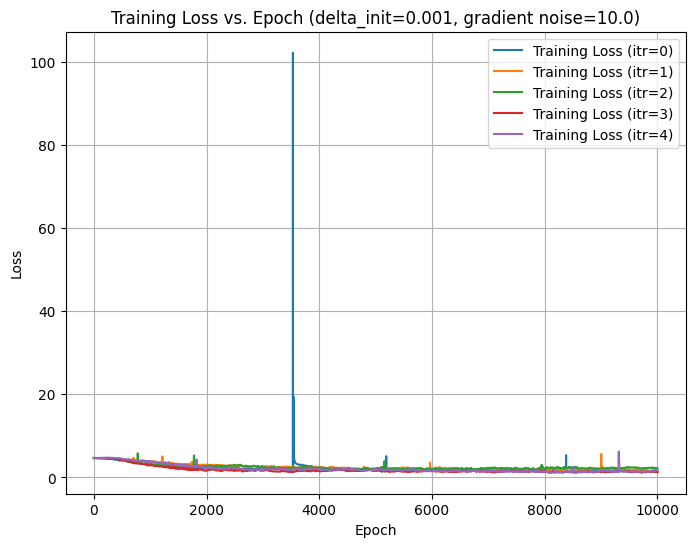

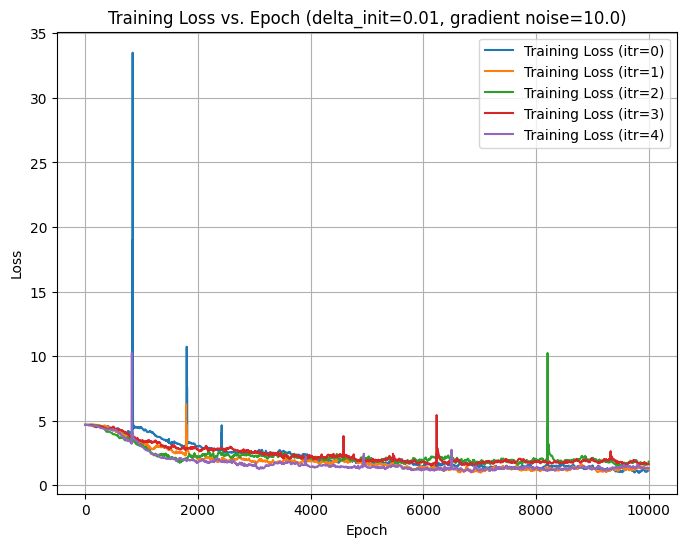

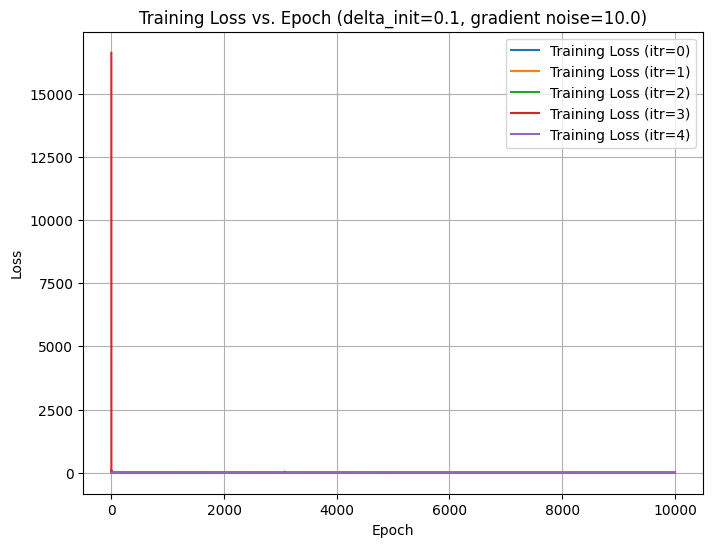

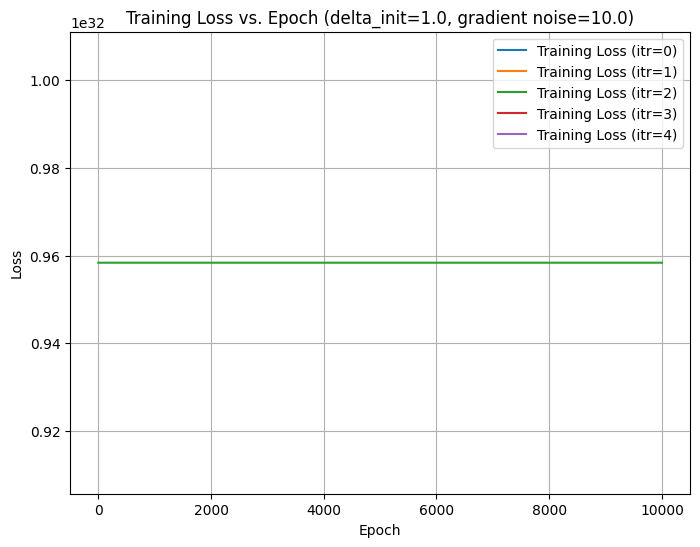

In [25]:
# Hyperparameters for Adam optimizer
lr = 0.005
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# number of iteration of experiments
num_itr = 5

# Function to apply Adam updates with added noise to the gradient
def adam_step(params, grads, m, v, t, lr, beta1, beta2, epsilon, noise_scale):
    updated_params = []
    for idx, (param, grad) in enumerate(zip(params, grads)):
        # Add noise to gradient
        noisy_grad = grad + torch.randn_like(grad) * noise_scale

        # Update biased first moment estimate
        m[idx] = beta1 * m[idx] + (1 - beta1) * noisy_grad

        # Update biased second moment estimate
        v[idx] = beta2 * v[idx] + (1 - beta2) * (noisy_grad ** 2)

        # Compute bias-corrected first moment estimate
        m_hat = m[idx] / (1 - beta1 ** t)

        # Compute bias-corrected second moment estimate
        v_hat = v[idx] / (1 - beta2 ** t)

        # Update parameters
        param_update = param - lr * m_hat / (torch.sqrt(v_hat) + epsilon)
        updated_params.append(param_update)

    return updated_params, m, v

delta_init_choice = [0.001, 0.01, 0.1, 1.0]
noise_choice = [2.0 * i for i in range(1,6)]

train_x, train_y, _ = generate_data(batch_size, d, n, device)

for noise_idx in range(len(noise_choice)):
    noise = noise_choice[noise_idx]
    for delta_idx in range(len(delta_init_choice)):
        delta_init = delta_init_choice[delta_idx]
        train_losses = []
        for itr in range(num_itr):
            # initialize the model, optimizer, and loss function
            model = LinearTransformer(d=d, n=n, L=L, delta_init=delta_init, device=device).to(device)

            # Adam's momentum (m) and second moment (v) terms
            m = [torch.zeros_like(param) for param in model.parameters()]
            v = [torch.zeros_like(param) for param in model.parameters()]

            train_losses_this_time = []

            for epoch in range(epochs):
                model.train()

                # zero-out gradients manually before each training step
                for param in model.parameters():
                    if param.grad is not None:
                        param.grad.zero_()

                # forward pass and loss calculation
                Z0 = torch.cat((torch.transpose(train_x,1,2), train_y.unsqueeze(1)), dim=1)  # concatenating x and y to form Z
                Z0[:,-1,-1] = 0 # initialize y_{n+1} as 0
                ZL = model(Z0)  # Apply the linear transformer
                train_loss = loss_function(ZL, train_y[:,-1])

                # backward pass and manual Adam update with noise
                grads = torch.autograd.grad(train_loss, model.parameters(), create_graph=False)

                # Set updated parameters back to the model
                with torch.no_grad():
                    # manually perform an Adam step with noisy gradients
                    updated_params, m, v = adam_step(list(model.parameters()), grads, m, v, epoch+1, lr, beta1, beta2, epsilon, noise_scale=noise)
                    for param, updated_param in zip(model.parameters(), updated_params):
                        param.copy_(updated_param)


                train_losses_this_time.append(train_loss.item())
            train_losses.append(train_losses_this_time)

        # Plot the loss over epochs
        plt.figure(figsize=(8, 6))
        for itr in range(num_itr):
            plt.plot(range(1, epochs+1), train_losses[itr], label=f'Training Loss (itr={itr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training Loss vs. Epoch (delta_init={delta_init}, gradient noise={noise})')
        plt.legend()
        plt.grid(True)
        plt.show()

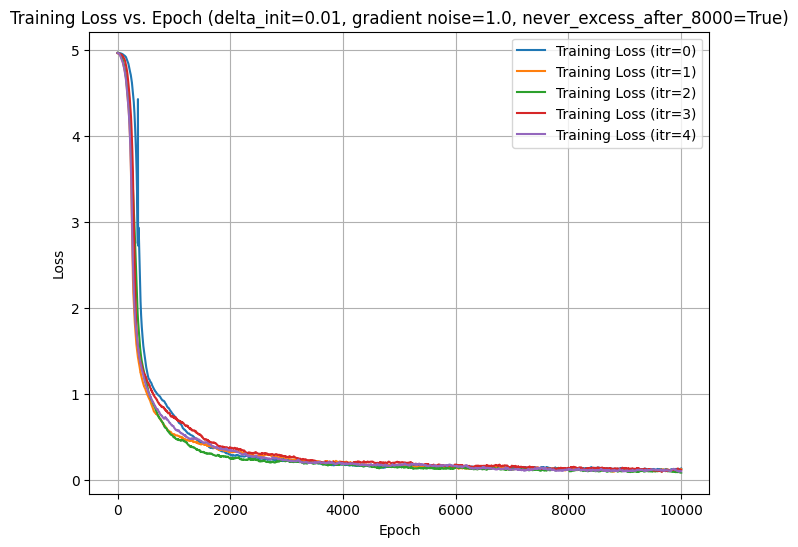

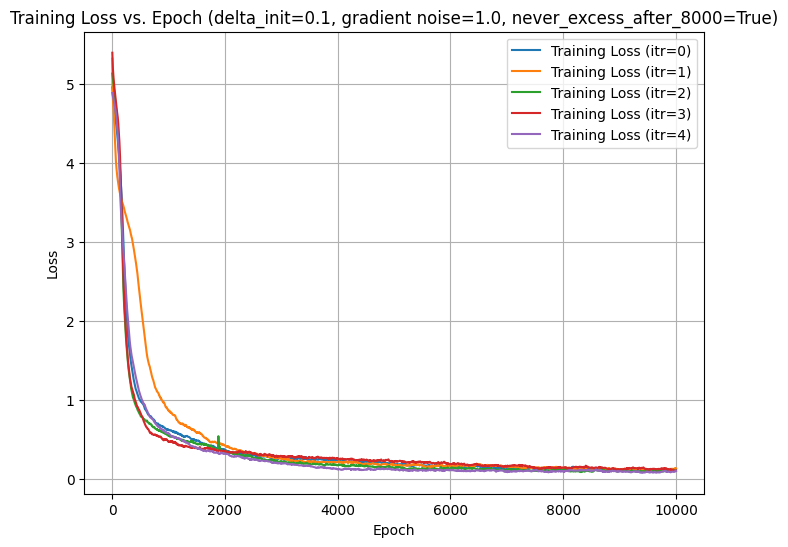

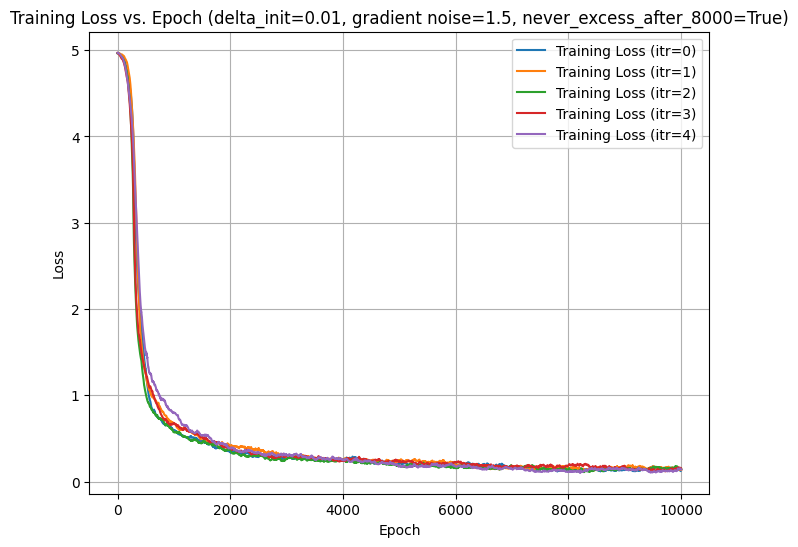

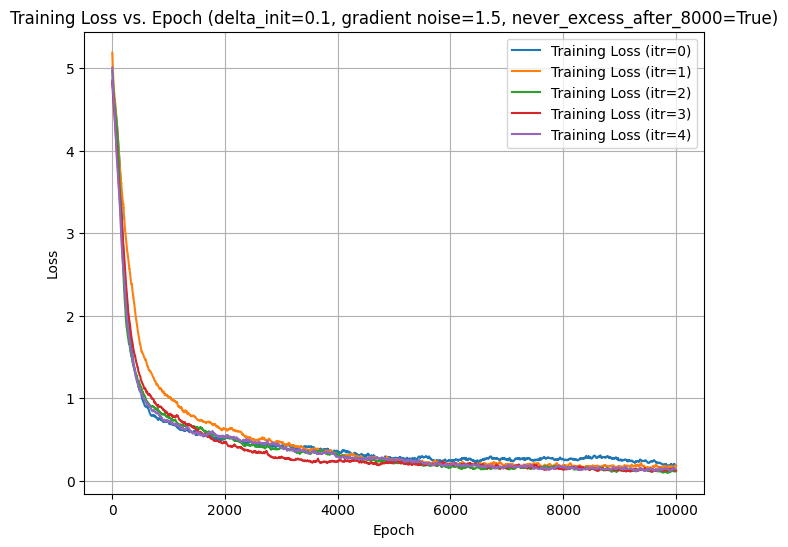

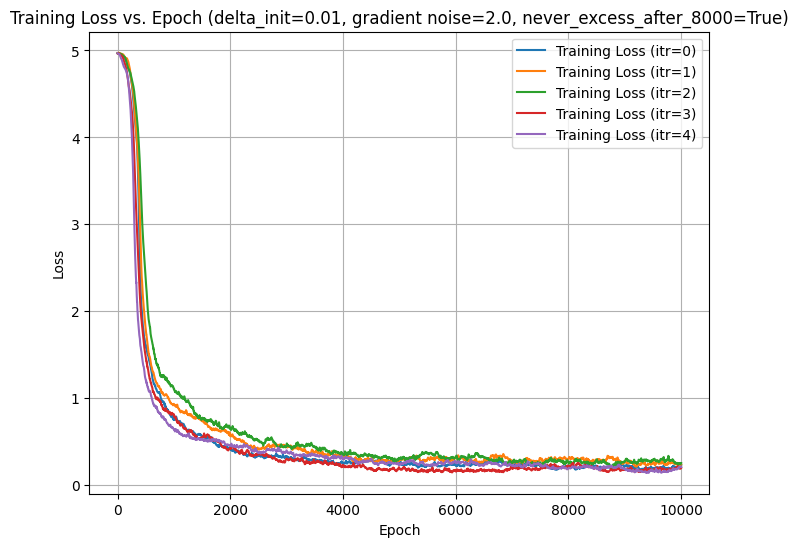

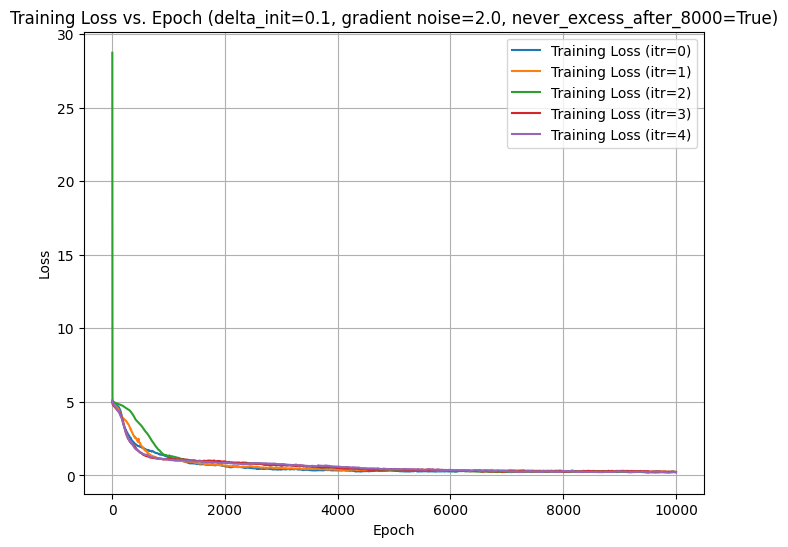

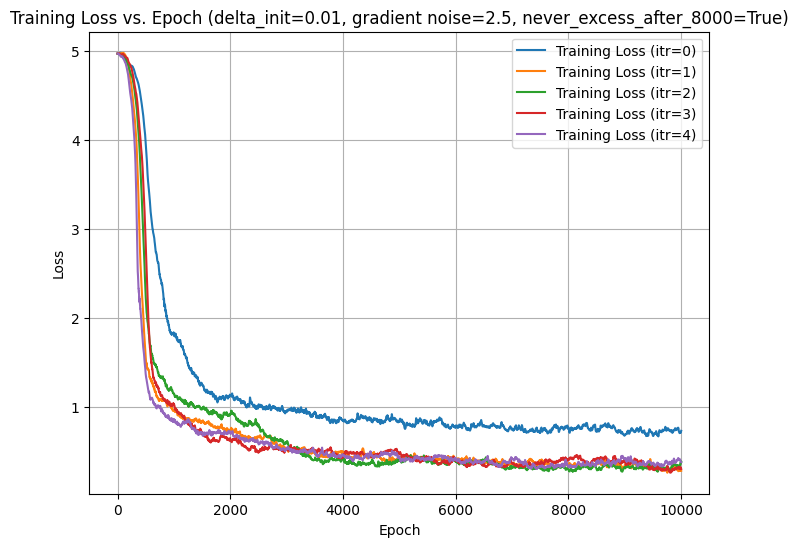

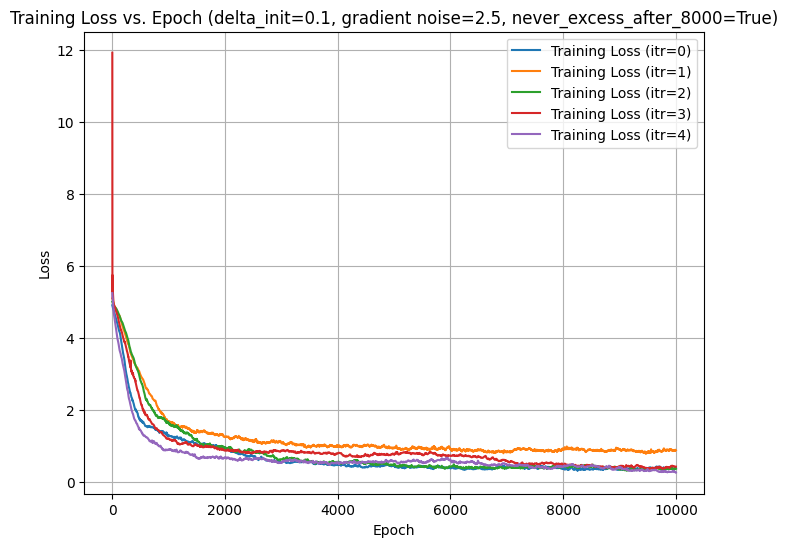

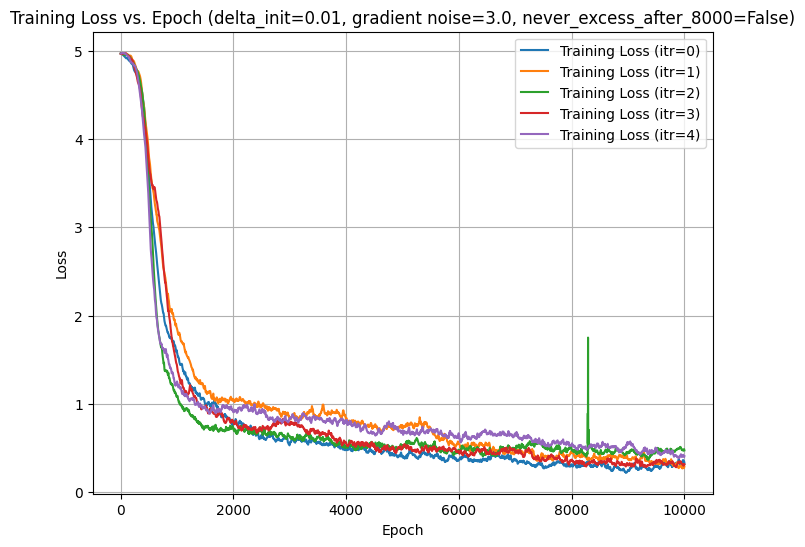

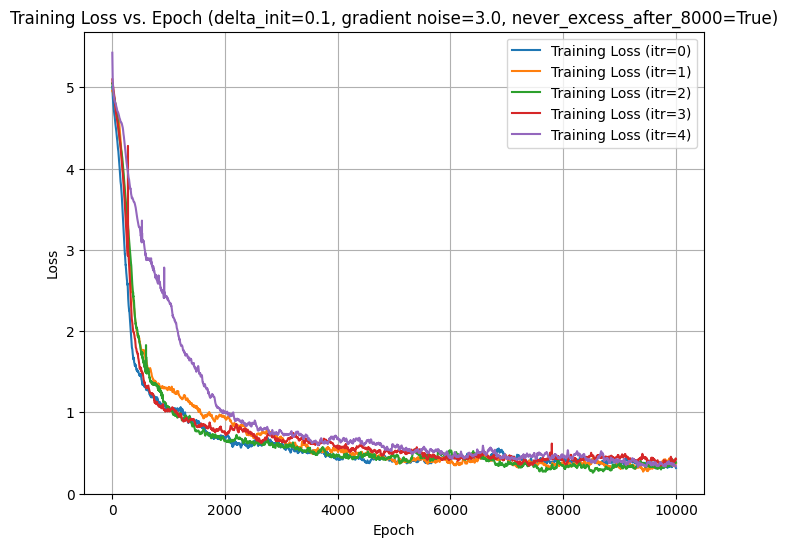

In [26]:
# Hyperparameters for Adam optimizer
lr = 0.005
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# number of iteration of experiments
num_itr = 5

# Function to apply Adam updates with added noise to the gradient
def adam_step(params, grads, m, v, t, lr, beta1, beta2, epsilon, noise_scale):
    updated_params = []
    for idx, (param, grad) in enumerate(zip(params, grads)):
        # Add noise to gradient
        noisy_grad = grad + torch.randn_like(grad) * noise_scale

        # Update biased first moment estimate
        m[idx] = beta1 * m[idx] + (1 - beta1) * noisy_grad

        # Update biased second moment estimate
        v[idx] = beta2 * v[idx] + (1 - beta2) * (noisy_grad ** 2)

        # Compute bias-corrected first moment estimate
        m_hat = m[idx] / (1 - beta1 ** t)

        # Compute bias-corrected second moment estimate
        v_hat = v[idx] / (1 - beta2 ** t)

        # Update parameters
        param_update = param - lr * m_hat / (torch.sqrt(v_hat) + epsilon)
        updated_params.append(param_update)

    return updated_params, m, v

delta_init_choice = [0.01, 0.1]
noise_choice = [1.0, 1.5, 2.0, 2.5, 3.0]

train_x, train_y, _ = generate_data(batch_size, d, n, device)
epsilon = 1.0

for noise_idx in range(len(noise_choice)):
    noise = noise_choice[noise_idx]
    for delta_idx in range(len(delta_init_choice)):
        delta_init = delta_init_choice[delta_idx]
        train_losses = []
        boolean_never_excess_epsilon = True
        for itr in range(num_itr):
            # initialize the model, optimizer, and loss function
            model = LinearTransformer(d=d, n=n, L=L, delta_init=delta_init, device=device).to(device)

            # Adam's momentum (m) and second moment (v) terms
            m = [torch.zeros_like(param) for param in model.parameters()]
            v = [torch.zeros_like(param) for param in model.parameters()]

            train_losses_this_time = []

            for epoch in range(epochs):
                model.train()

                # zero-out gradients manually before each training step
                for param in model.parameters():
                    if param.grad is not None:
                        param.grad.zero_()

                # forward pass and loss calculation
                Z0 = torch.cat((torch.transpose(train_x,1,2), train_y.unsqueeze(1)), dim=1)  # concatenating x and y to form Z
                Z0[:,-1,-1] = 0 # initialize y_{n+1} as 0
                ZL = model(Z0)  # Apply the linear transformer
                train_loss = loss_function(ZL, train_y[:,-1])
                boolean_never_excess_epsilon = boolean_never_excess_epsilon and (epoch < 8000 or train_loss < 1.0)

                # backward pass and manual Adam update with noise
                grads = torch.autograd.grad(train_loss, model.parameters(), create_graph=False)

                # Set updated parameters back to the model
                with torch.no_grad():
                    # manually perform an Adam step with noisy gradients
                    updated_params, m, v = adam_step(list(model.parameters()), grads, m, v, epoch+1, lr, beta1, beta2, epsilon, noise_scale=noise)
                    for param, updated_param in zip(model.parameters(), updated_params):
                        param.copy_(updated_param)


                train_losses_this_time.append(train_loss.item())
            train_losses.append(train_losses_this_time)

        # Plot the loss over epochs
        plt.figure(figsize=(8, 6))
        for itr in range(num_itr):
            plt.plot(range(1, epochs+1), train_losses[itr], label=f'Training Loss (itr={itr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training Loss vs. Epoch (delta_init={delta_init}, gradient noise={noise}, never_excess_after_8000={boolean_never_excess_epsilon})')
        plt.legend()
        plt.grid(True)
        plt.show()

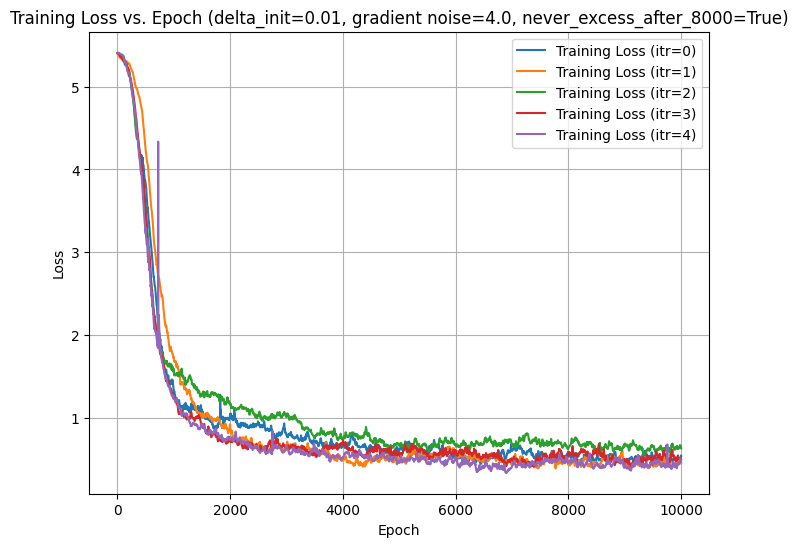

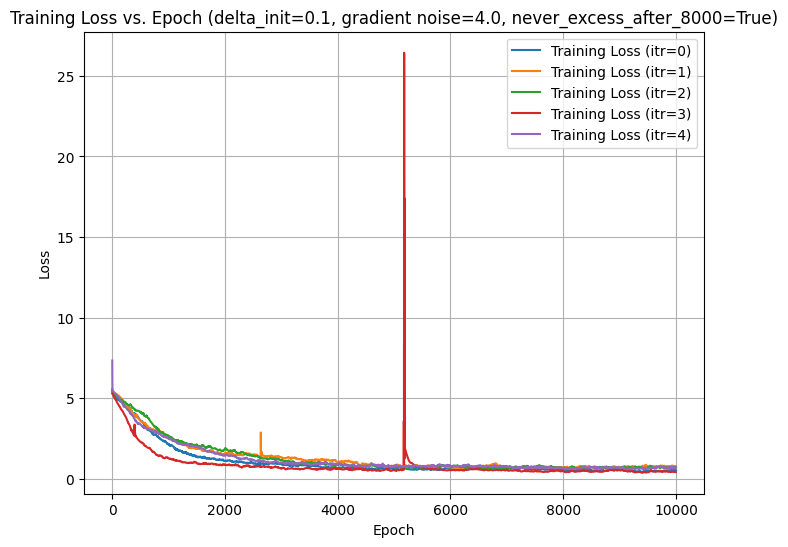

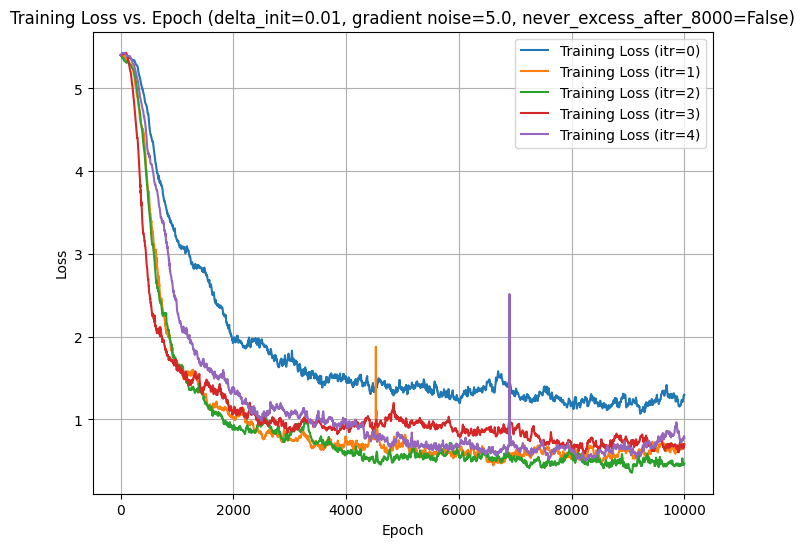

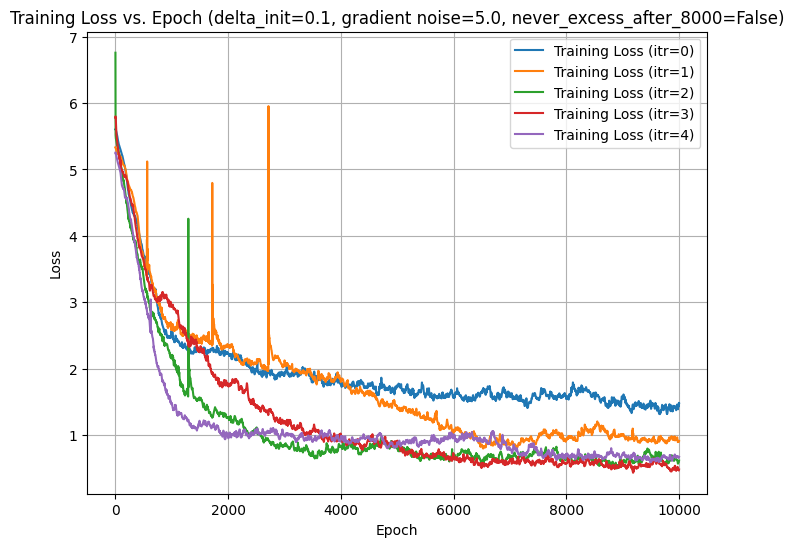

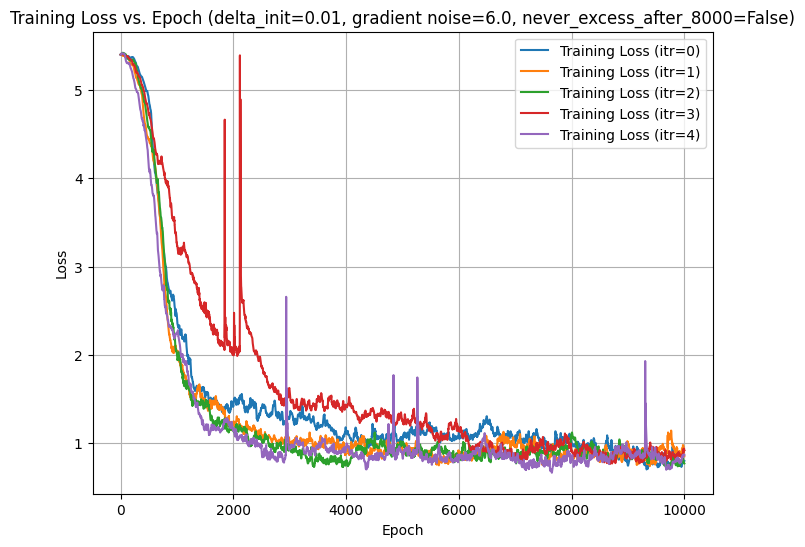

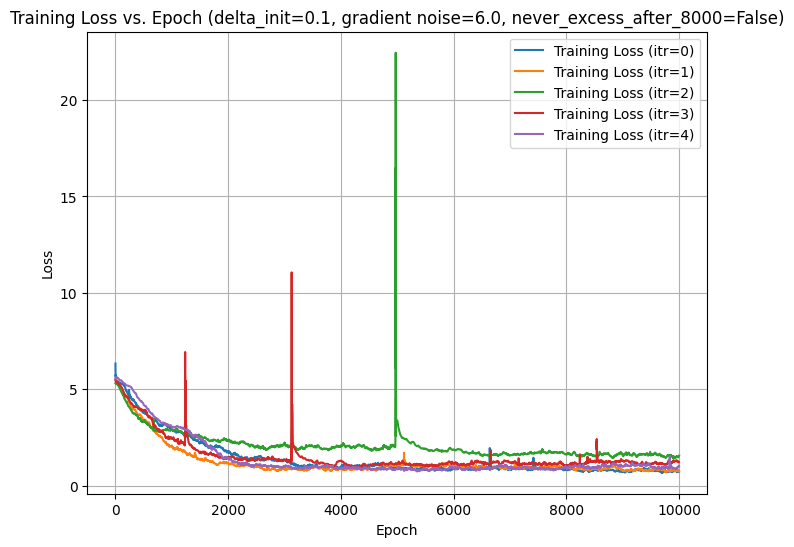

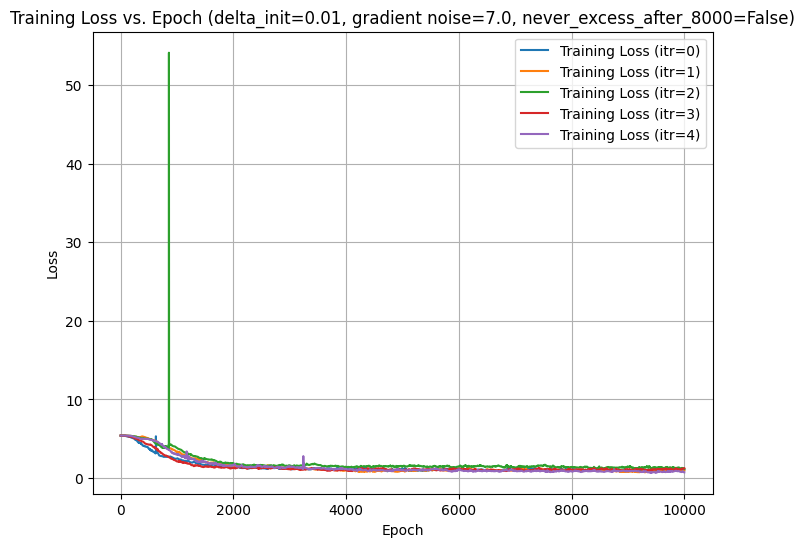

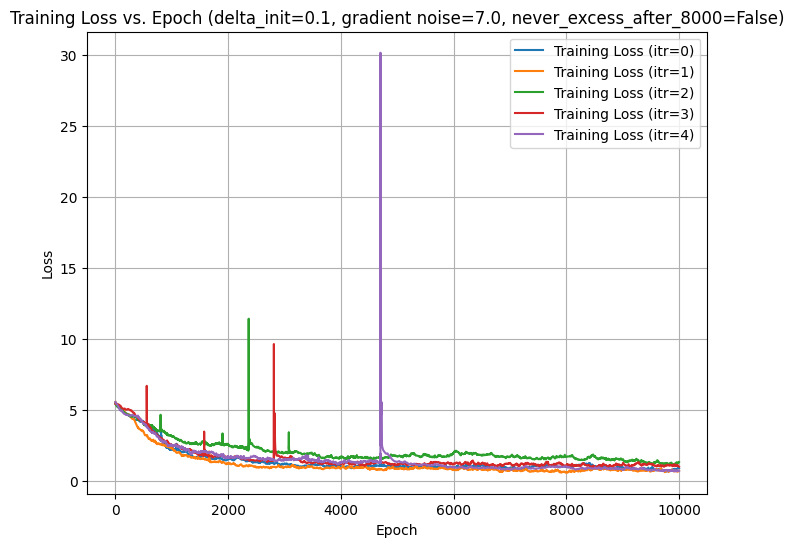

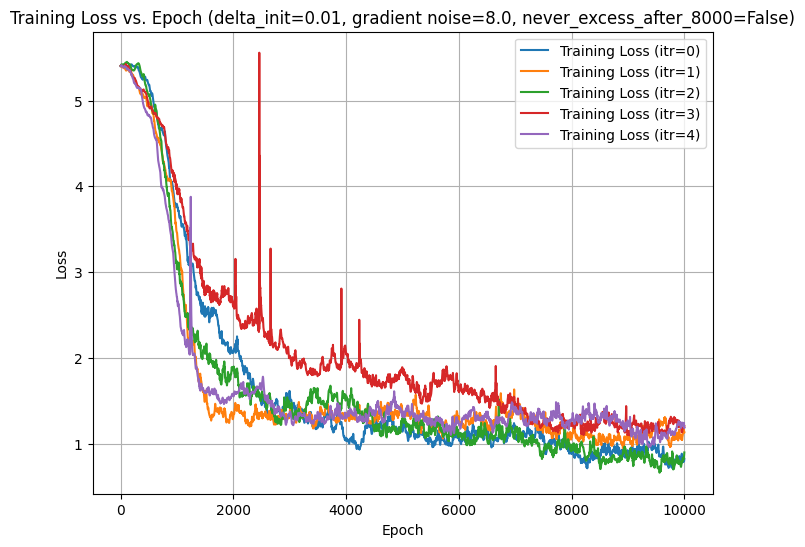

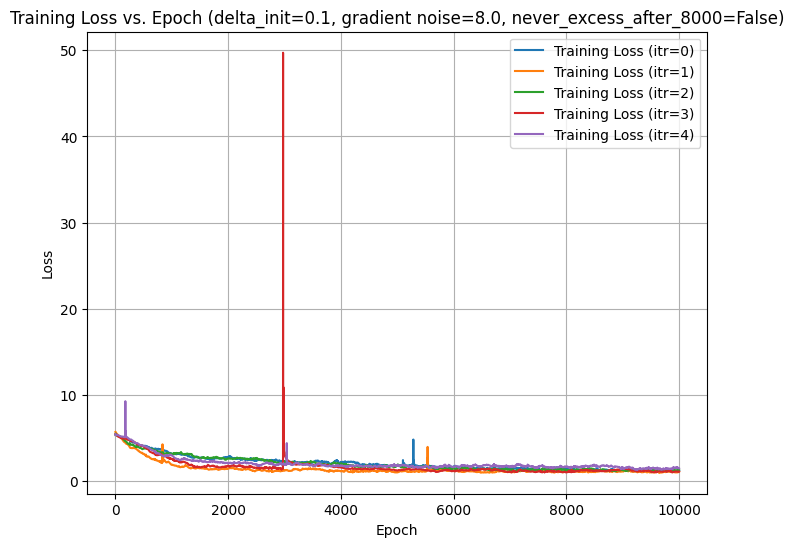

In [27]:
# Hyperparameters for Adam optimizer
lr = 0.005
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# number of iteration of experiments
num_itr = 5

# Function to apply Adam updates with added noise to the gradient
def adam_step(params, grads, m, v, t, lr, beta1, beta2, epsilon, noise_scale):
    updated_params = []
    for idx, (param, grad) in enumerate(zip(params, grads)):
        # Add noise to gradient
        noisy_grad = grad + torch.randn_like(grad) * noise_scale

        # Update biased first moment estimate
        m[idx] = beta1 * m[idx] + (1 - beta1) * noisy_grad

        # Update biased second moment estimate
        v[idx] = beta2 * v[idx] + (1 - beta2) * (noisy_grad ** 2)

        # Compute bias-corrected first moment estimate
        m_hat = m[idx] / (1 - beta1 ** t)

        # Compute bias-corrected second moment estimate
        v_hat = v[idx] / (1 - beta2 ** t)

        # Update parameters
        param_update = param - lr * m_hat / (torch.sqrt(v_hat) + epsilon)
        updated_params.append(param_update)

    return updated_params, m, v

delta_init_choice = [0.01, 0.1]
noise_choice = [4.0,5.0,6.0,7.0,8.0]

train_x, train_y, _ = generate_data(batch_size, d, n, device)
epsilon = 1.0

for noise_idx in range(len(noise_choice)):
    noise = noise_choice[noise_idx]
    for delta_idx in range(len(delta_init_choice)):
        delta_init = delta_init_choice[delta_idx]
        train_losses = []
        boolean_never_excess_epsilon = True
        for itr in range(num_itr):
            # initialize the model, optimizer, and loss function
            model = LinearTransformer(d=d, n=n, L=L, delta_init=delta_init, device=device).to(device)

            # Adam's momentum (m) and second moment (v) terms
            m = [torch.zeros_like(param) for param in model.parameters()]
            v = [torch.zeros_like(param) for param in model.parameters()]

            train_losses_this_time = []

            for epoch in range(epochs):
                model.train()

                # zero-out gradients manually before each training step
                for param in model.parameters():
                    if param.grad is not None:
                        param.grad.zero_()

                # forward pass and loss calculation
                Z0 = torch.cat((torch.transpose(train_x,1,2), train_y.unsqueeze(1)), dim=1)  # concatenating x and y to form Z
                Z0[:,-1,-1] = 0 # initialize y_{n+1} as 0
                ZL = model(Z0)  # Apply the linear transformer
                train_loss = loss_function(ZL, train_y[:,-1])
                boolean_never_excess_epsilon = boolean_never_excess_epsilon and (epoch < 8000 or train_loss < 1.0)

                # backward pass and manual Adam update with noise
                grads = torch.autograd.grad(train_loss, model.parameters(), create_graph=False)

                # Set updated parameters back to the model
                with torch.no_grad():
                    # manually perform an Adam step with noisy gradients
                    updated_params, m, v = adam_step(list(model.parameters()), grads, m, v, epoch+1, lr, beta1, beta2, epsilon, noise_scale=noise)
                    for param, updated_param in zip(model.parameters(), updated_params):
                        param.copy_(updated_param)


                train_losses_this_time.append(train_loss.item())
            train_losses.append(train_losses_this_time)

        # Plot the loss over epochs
        plt.figure(figsize=(8, 6))
        for itr in range(num_itr):
            plt.plot(range(1, epochs+1), train_losses[itr], label=f'Training Loss (itr={itr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training Loss vs. Epoch (delta_init={delta_init}, gradient noise={noise}, never_excess_after_8000={boolean_never_excess_epsilon})')
        plt.legend()
        plt.grid(True)
        plt.show()

In [28]:
2+2

4